# Distributions of SHAP values by feature

## Plain English summary

This notebook looks at the variation in SHAP values across the 10,000 patients in the test data set. For each feature we find the mean and standard deviation of the SHAP values for later use.

## Sources

Data processing is copied from here: https://github.com/stroke-modelling/stroke-utilities/blob/main/docs/01_create_predictor_shap_and_benchmark_rankings.ipynb

Box plot creation is copied from here: https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

## Notebook setup:

In [2]:
import pandas as pd
import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt

import stroke_utilities.process_data as process_data

# Turn warnings off to keep notebook tidy
# import warnings
# warnings.filterwarnings("ignore")

import shap

import pickle


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'

paths = Paths()

## Import SHAP explainer

In [4]:
with open(f'{paths.model_folder}/shap_explainer.p', 'rb') as fp:
    explainer = pickle.load(fp)

## Load data

Import the data from file:

In [5]:
# Load data
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [6]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [7]:
test = test[features_to_model]

If the year of admission to stroke team is still in the data, restrict it to the following range.

Currently this process does nothing because we have already removed "year" from the data.

In [8]:
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [9]:
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [10]:
features = list(X_test)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model (and so its SHAP explainer), we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [11]:
X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [12]:
# Get features
feature_names_ohe = list(X_test)

# Print the first several...
print(feature_names_ohe[:15])
# ... and last few feature names:
print(feature_names_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Create SHAP values for the test data

Create SHAP values in log-odds units. Pass the X_test data to the explainer object:

In [13]:
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)

In [14]:
len(shap_values[0, :])

128

## Calculate mean SHAP values

The code is adapted from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

In [15]:
# Store summary results (mean, std) in this list:
arr = []
# Store full results (all SHAP values per category) in this dict:
std_dict = {}

for f, feature in enumerate(feature_names_ohe):
    # Get the original patient data for this feature:
    feature_data = shap_values_extended[:, feature].data
    # Get the matching SHAP values for this feature:
    feature_shap = shap_values_extended[:, feature].values

    if 'afib' in feature:
        # For the AF anticoagulant feature, currently some of the data
        # has a missing value rather than just "yes" or "no".
        # The missing data is stored as NaN (a float) but later we want
        # to convert all floats to ints. So change the NaN to an
        # obviously invalid integer:
        feature_data[(feature_data != 0) & (feature_data != 1)] = -1000

    # Place the data into categories and create names for the categories.
    # If feature has more that 50 unique values, then assume it needs to be 
    # binned (otherwise assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # Bin the data.
        
        # Bin settings:
        step = 30
        n_bins = int(min(11, (feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of names for bins (the unique categories).
        # Each label is e.g. "0-29" to show the range of binned data.
        category_list = [f'{i*step}-{((i+1)*step-1)}'
                         for i in range(n_bins-1)]
        # Add on the final value separately: e.g. "180+".
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(
            feature_data, bin_list, labels=category_list, right=False)
    else:
        # Keep unique feature values separate.
        # create names for unique categories in the feature data
        category_list = np.unique(feature_data)
        if (feature != "age"):
            # Age needs to keep its decimal value
            # (midpoint between 5 yrs).
            # Other features can be converted to integer:
            category_list = [int(i) for i in category_list]

    # Set up lists to store the results from each category.
    # These will be used to populate the dictionary `std_dict`.
    shap_per_category = []
    stds_per_category = []
    means_per_category = []
    for category in category_list:
        # Which data points belong to this category?
        mask = feature_data == category
        c = feature_shap[mask]

        # Store all of the separate SHAP values in this category:
        shap_per_category.append(c)

        # Calculate mean and standard deviation of all of the
        # separate SHAP values for this category and store:
        s = np.std(c)
        m = np.mean(c)
        stds_per_category.append(s)
        means_per_category.append(m)

        # Store the feature name, its value, its mean and its std.
        # This will go in the summary list of lists `arr`.
        row = [feature, category, m, s]
        arr.append(row)

    # Convert the sets of full results into a single dictionary entry:
    std_dict[feature] = {
        'feature_data': feature_data,
        'feature_shap': feature_shap,
        'category_list': category_list,
        'shap_per_category': shap_per_category,
        'means_per_category': means_per_category,
        'stds_per_category': stds_per_category,
    }

Put the main results into a DataFrame and save to file:

In [16]:
df_std_shap = pd.DataFrame(arr, columns=['feature', 'feature_value', 'mean_shap', 'std_shap'])

df_std_shap

,feature,feature_value,mean_shap,std_shap
0,stroke_severity,0,-2.759728,0.476846
1,stroke_severity,1,-2.410901,0.420371
2,stroke_severity,2,-1.625403,0.301874
3,stroke_severity,3,-0.987334,0.250921
4,stroke_severity,4,-0.256834,0.170533
...,...,...,...,...
316,team_117,1,-0.688748,0.286864
317,team_118,0,-0.005982,0.002915
318,team_118,1,0.667060,0.340155
319,team_119,0,0.000004,0.000719


In [17]:
df_std_shap.to_csv('./uncertainty/shap_std.csv', index=False)

## Plot the distributions of SHAP values

The full distributions of SHAP values were stored in a dictionary earlier. Pull out the values and make violin plots.

In [40]:
def plot_violins(shap_dict, feature=''):
    fig, ax = plt.subplots()
    # Show the distribution of SHAP values:
    ax.violinplot(shap_dict['shap_per_category'])
    # Draw an errorbar centred on the mean with size +/- 1 std.
    ax.errorbar(
        range(1, len(shap_dict['category_list']) + 1),
        shap_dict['means_per_category'],
        yerr=np.array(shap_dict['stds_per_category']),
        capsize=10,
        marker='o',
        markersize=3,
        linestyle='',
        color='k',
        label=r'Mean $\pm$ std'
    )
    # Draw a horizontal line at SHAP=0:
    ax.axhline(0, color='k', linewidth=0.5)
    # Labels:
    ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    ax.set_xticks(range(1, len(shap_dict['category_list']) + 1))
    ax.set_xticklabels(shap_dict['category_list'])
    ax.set_xlabel('Value')
    ax.set_ylabel('SHAP')
    ax.set_title(feature)
    plt.show()

### Non-team features

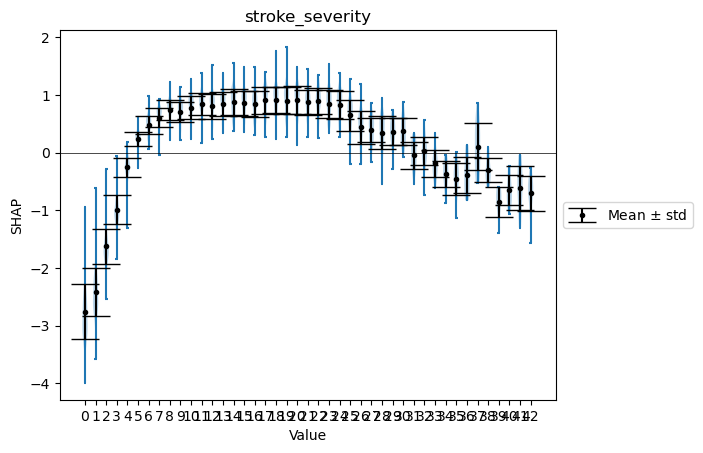

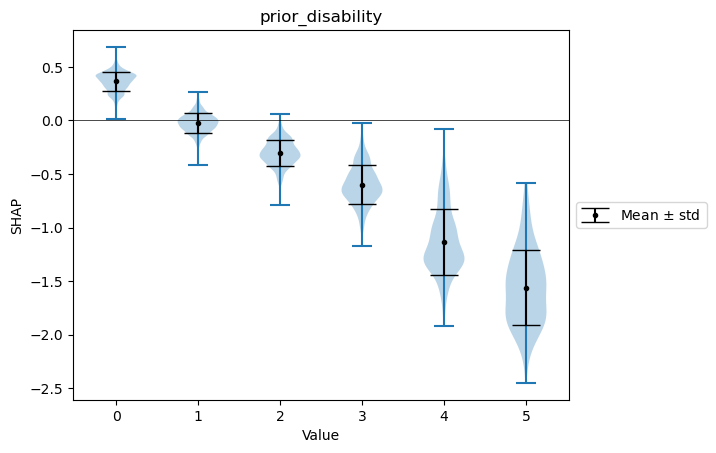

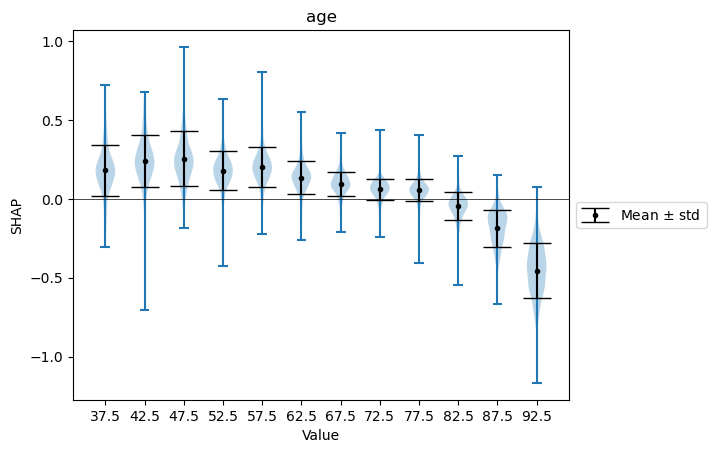

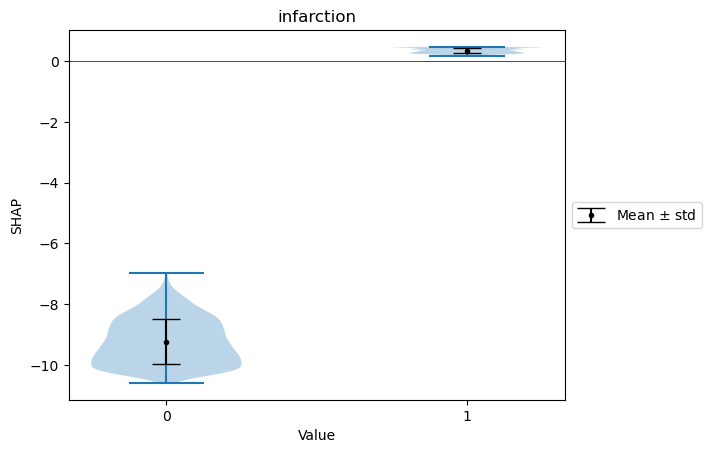

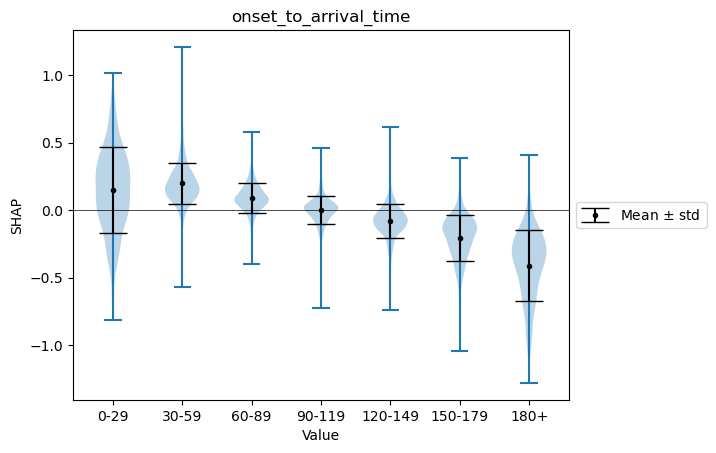

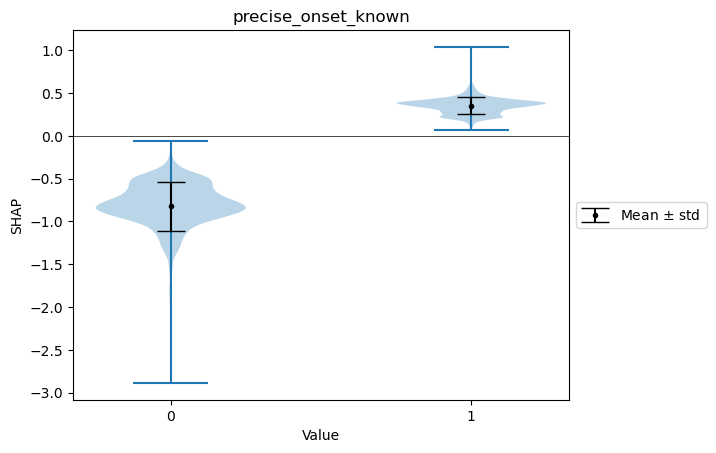

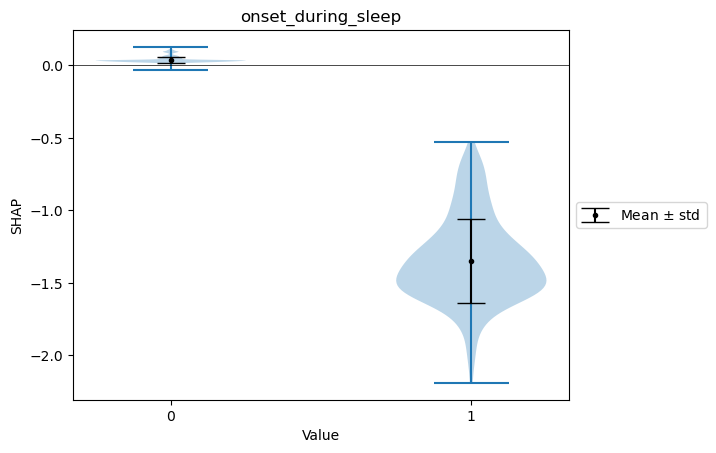

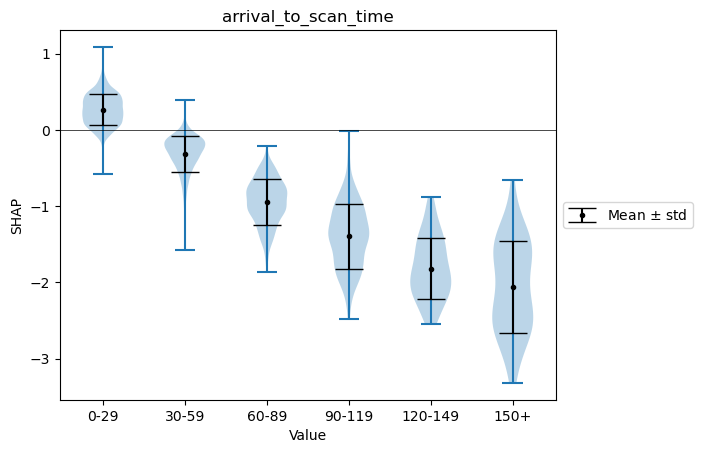

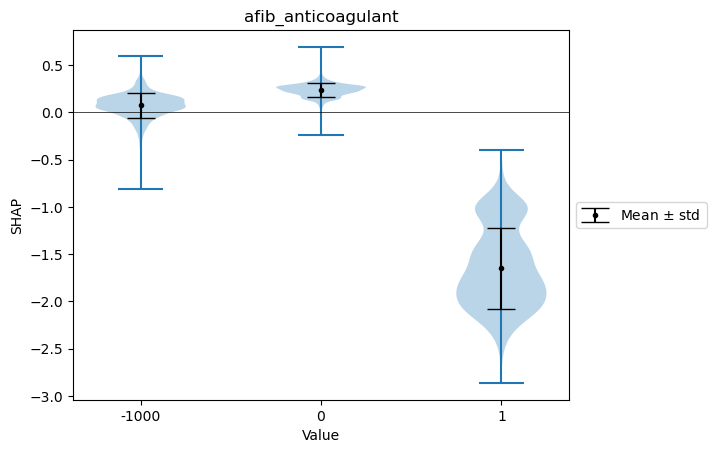

In [41]:
for f, feature in enumerate(feature_names_ohe[:9]):
    shap_dict = std_dict[feature]
    plot_violins(shap_dict, feature)

### Individual teams

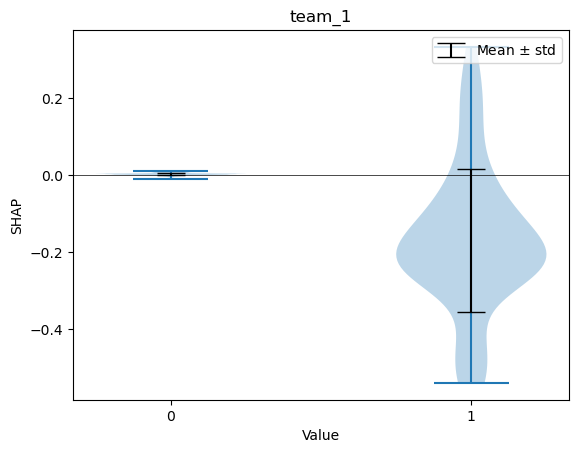

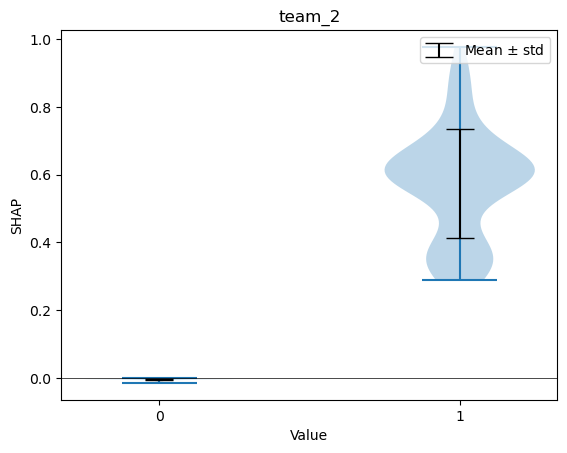

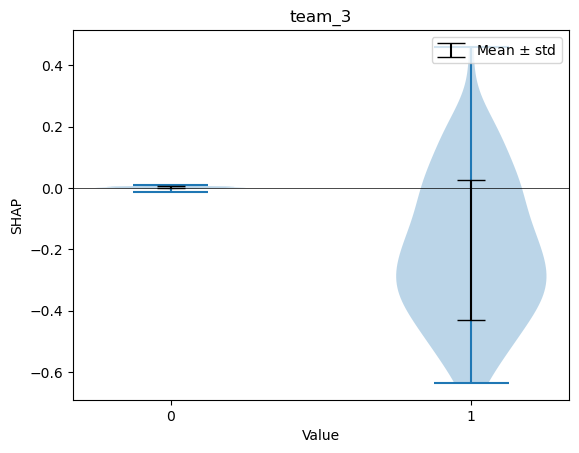

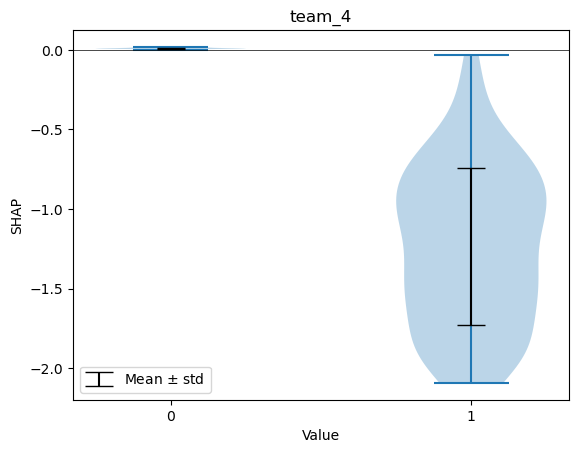

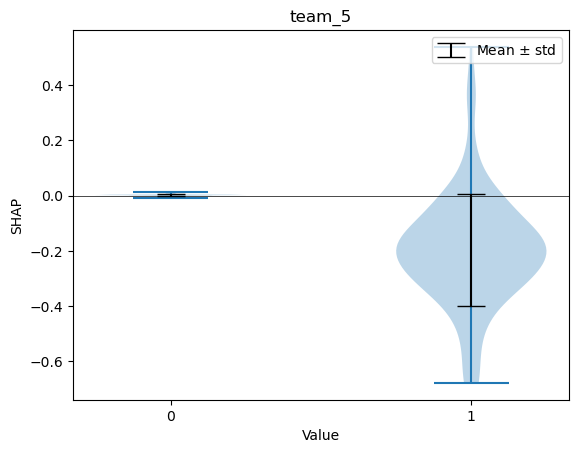

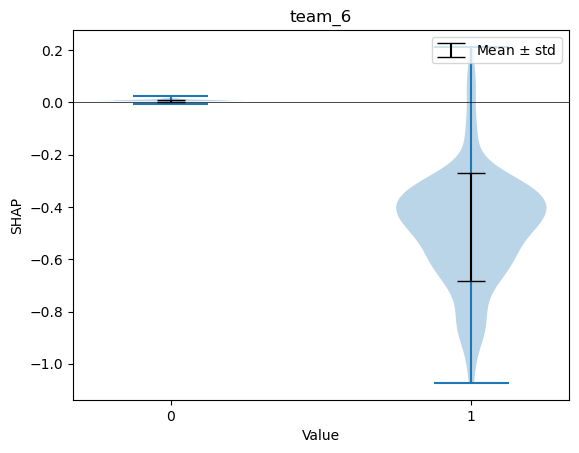

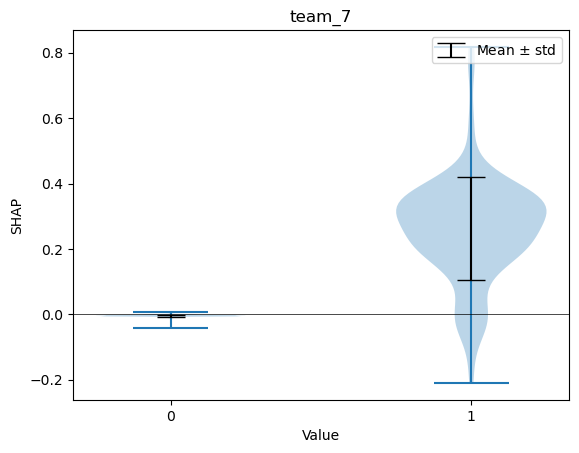

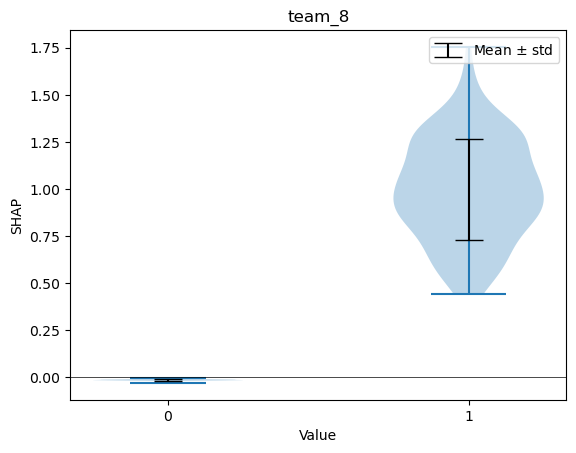

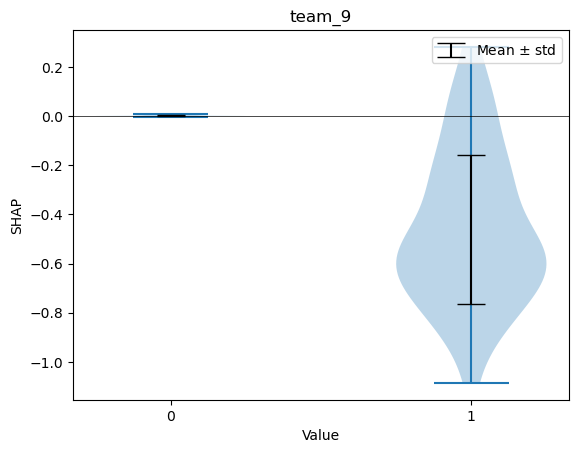

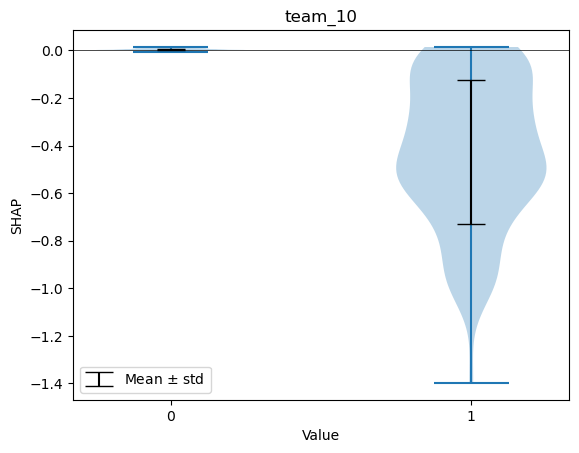

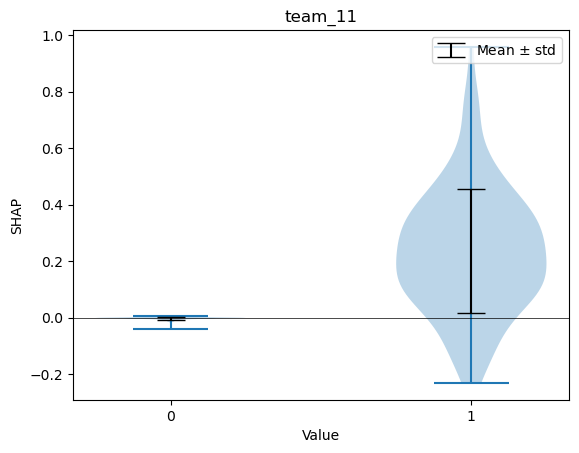

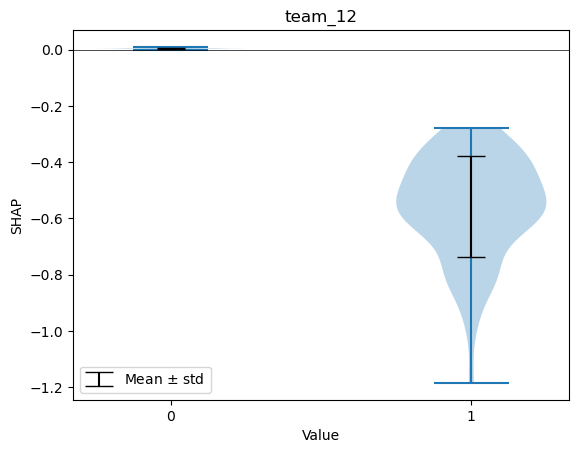

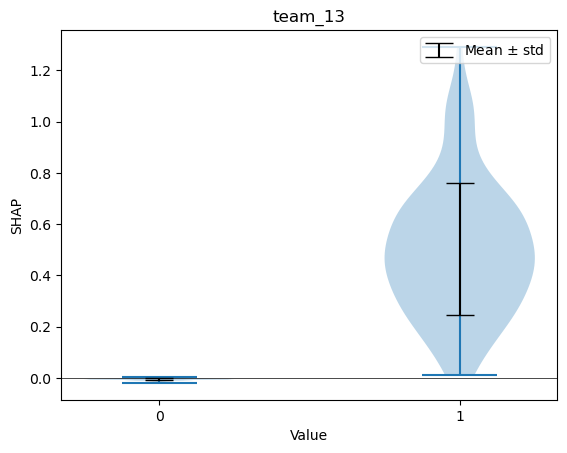

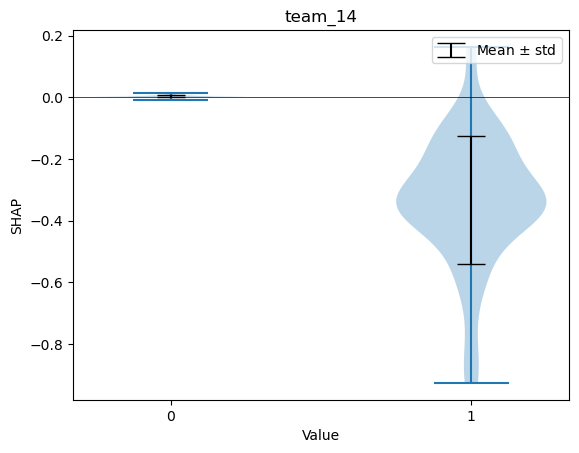

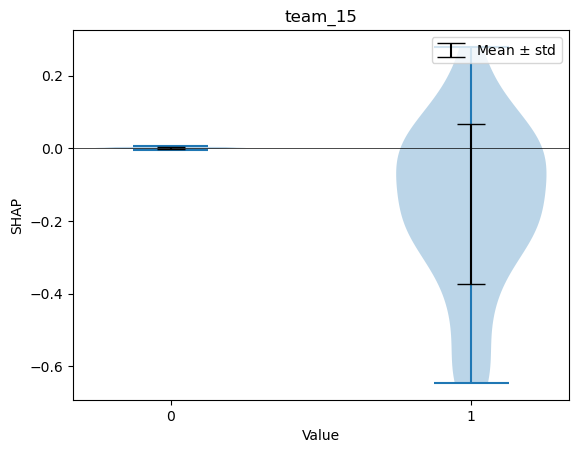

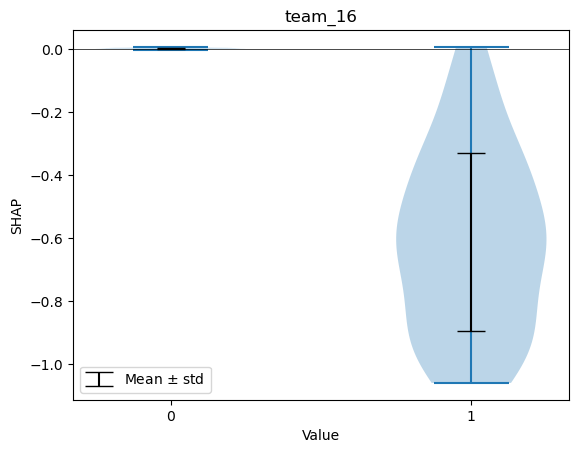

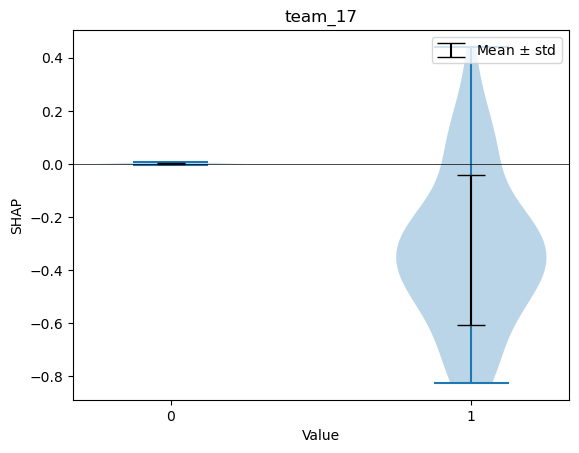

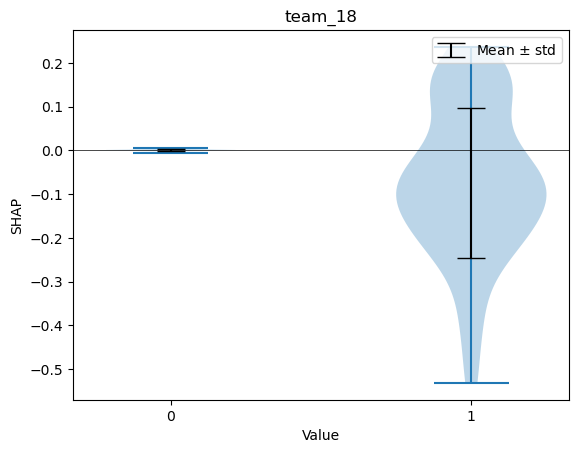

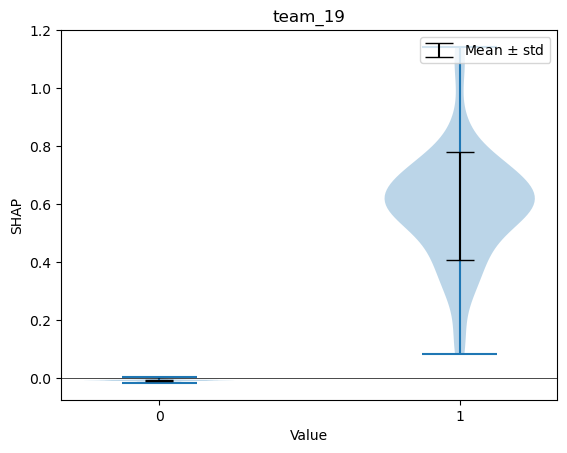

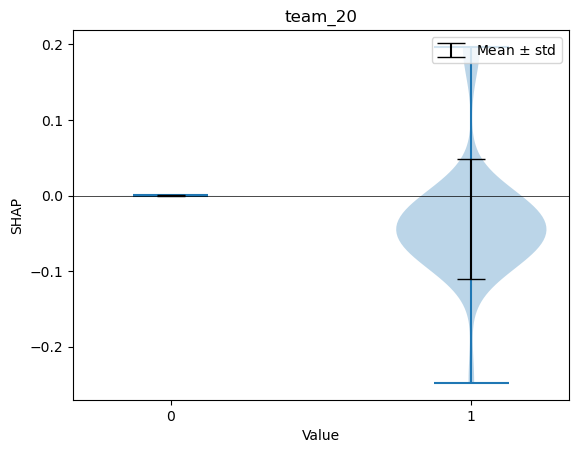

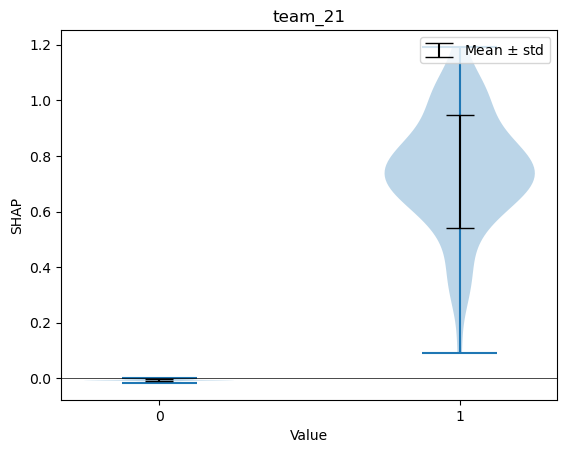

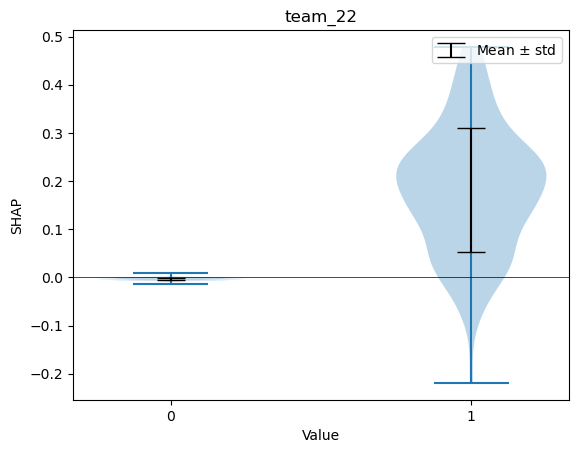

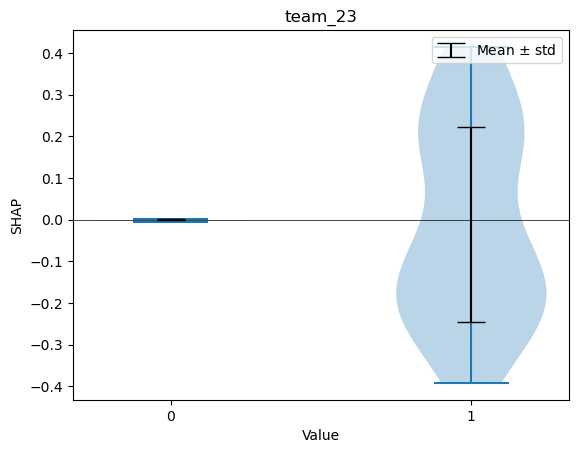

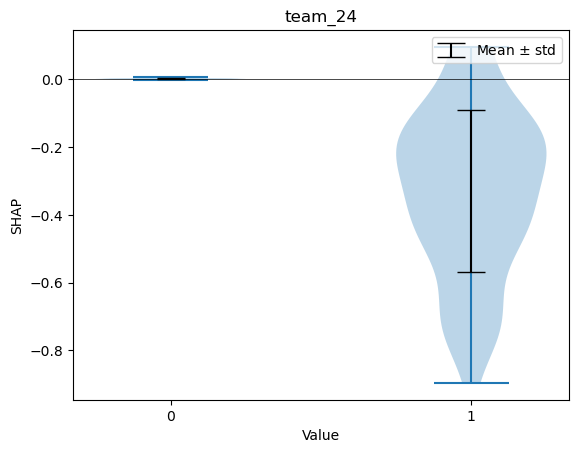

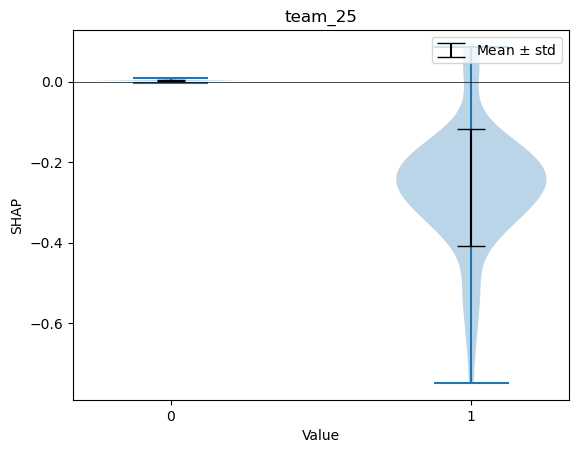

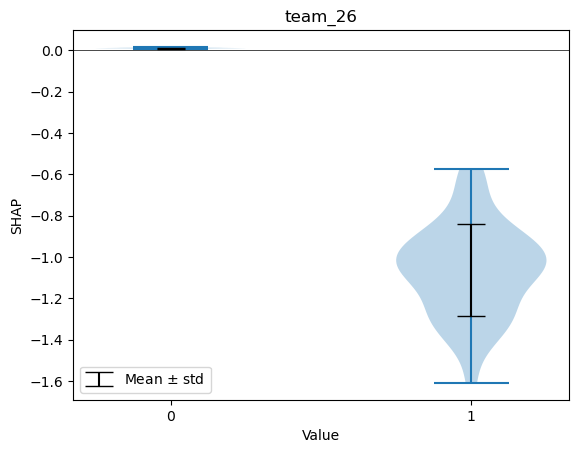

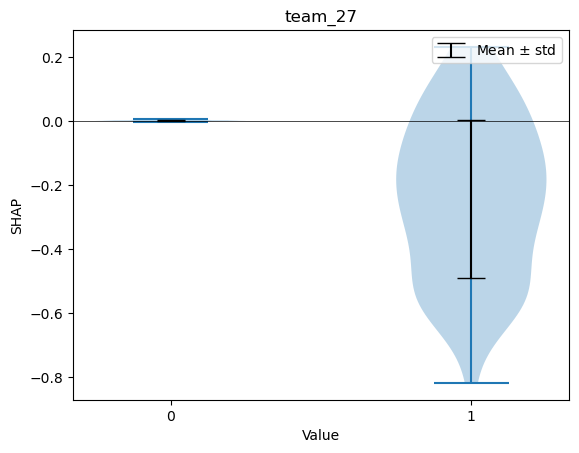

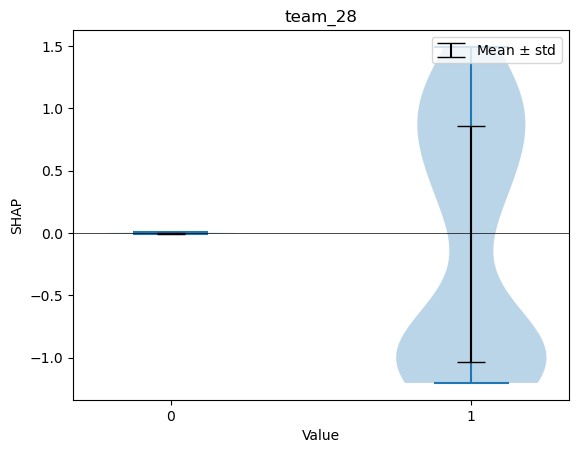

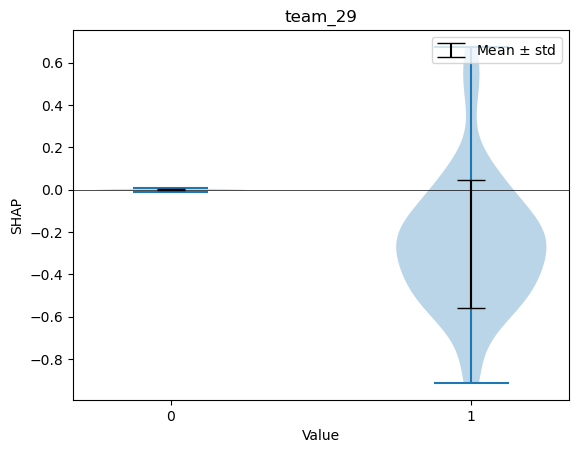

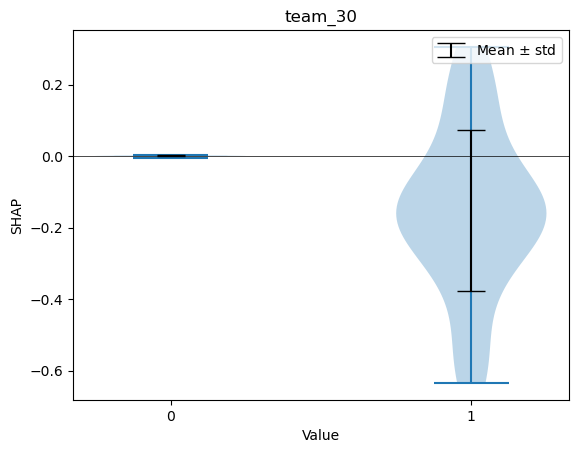

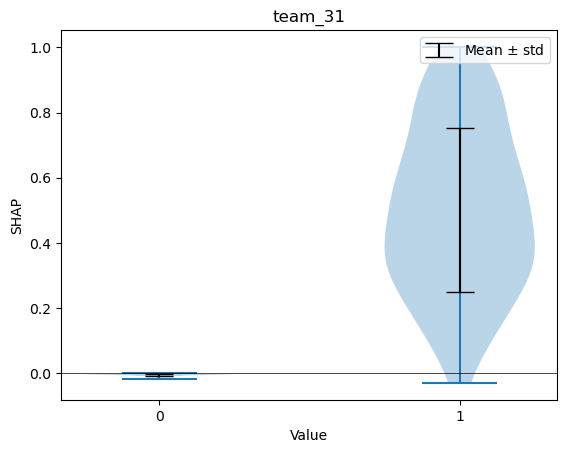

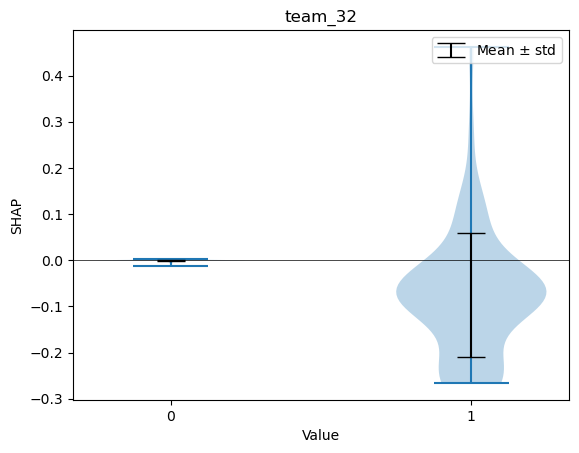

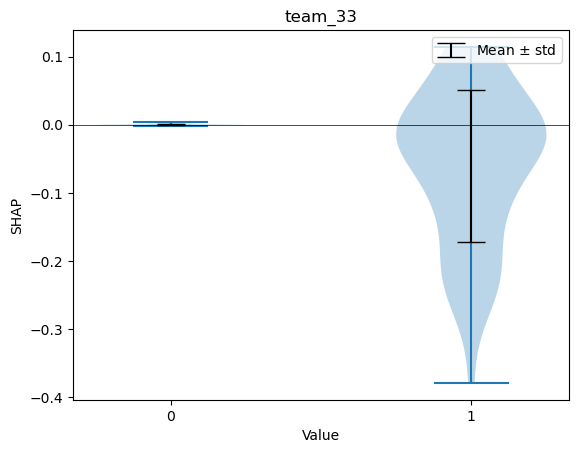

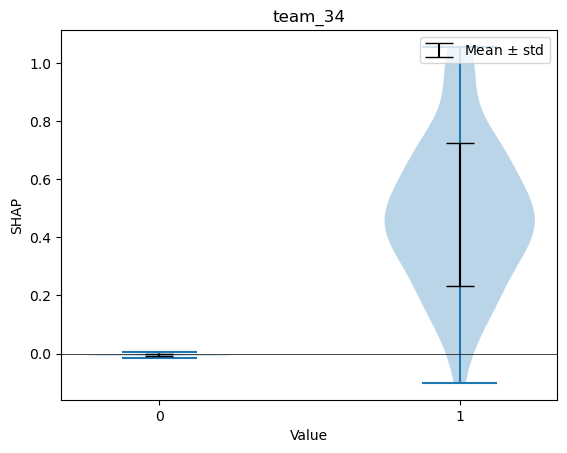

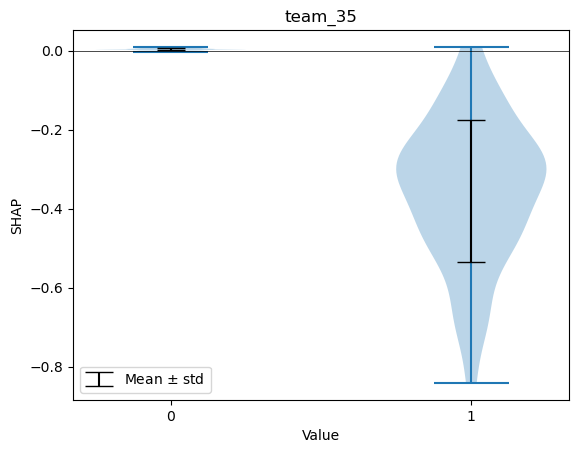

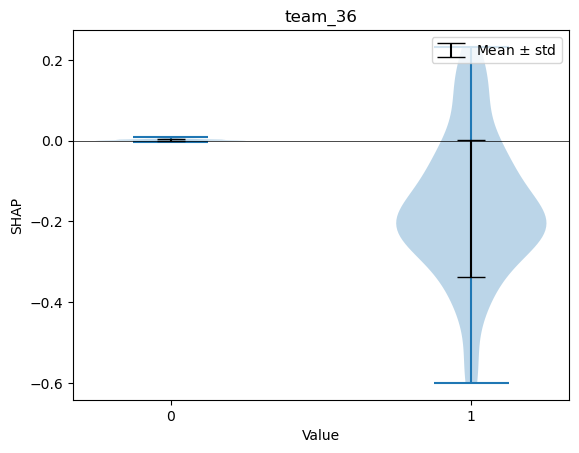

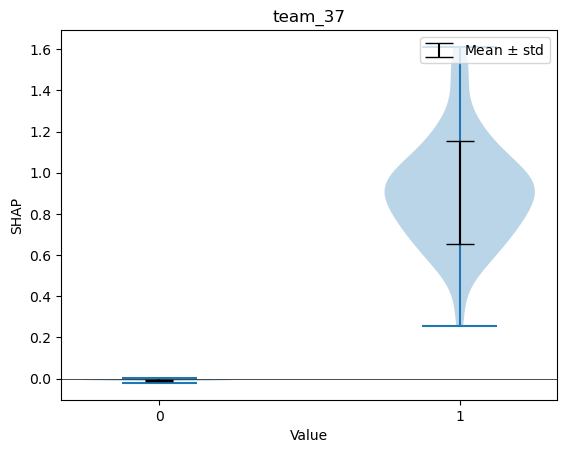

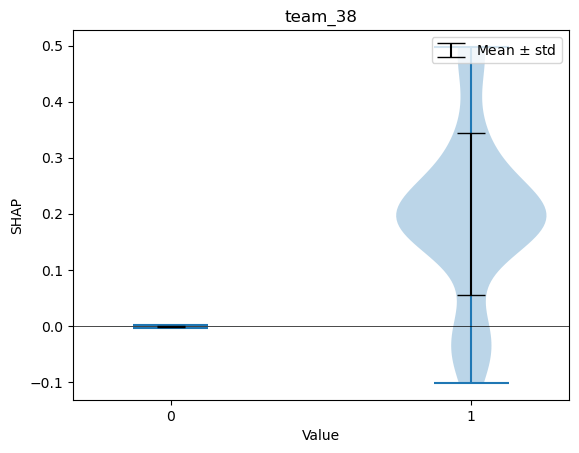

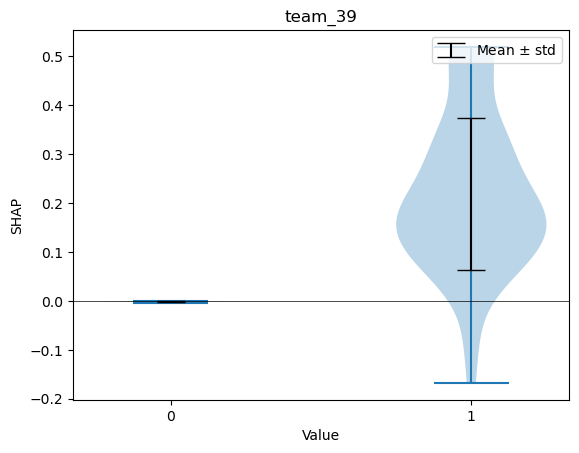

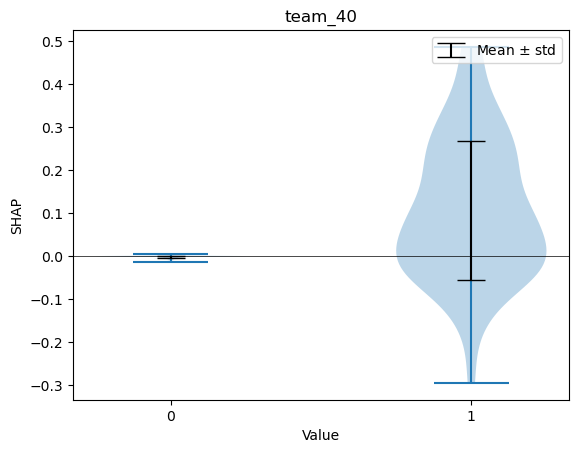

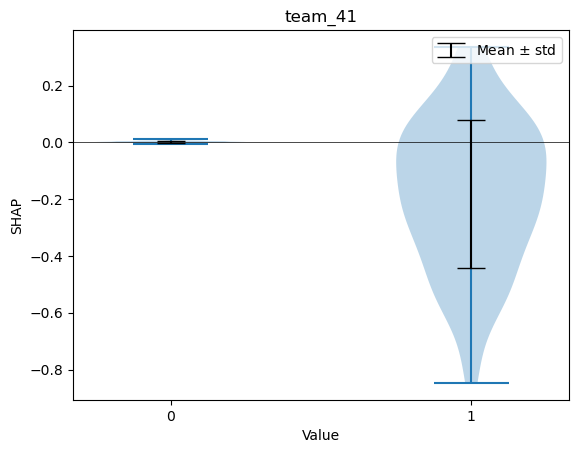

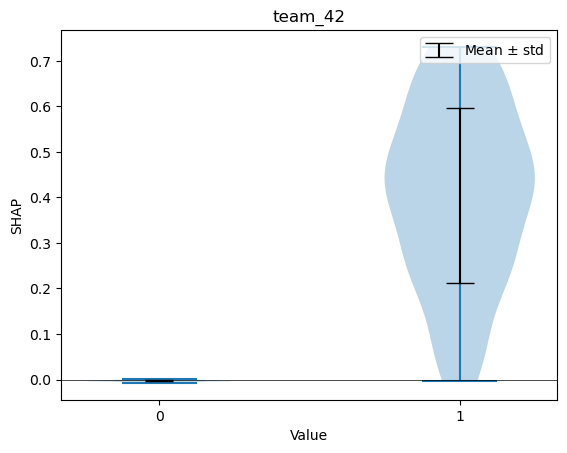

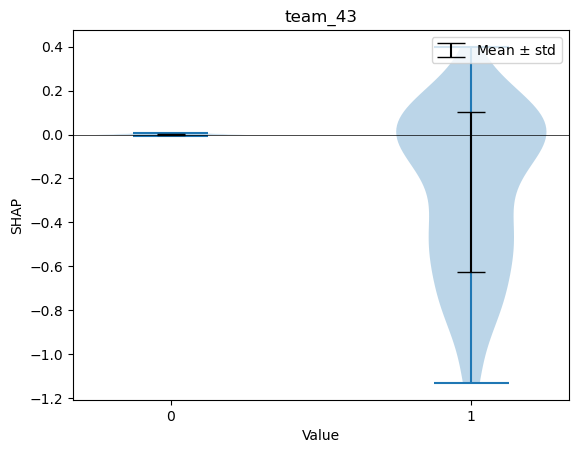

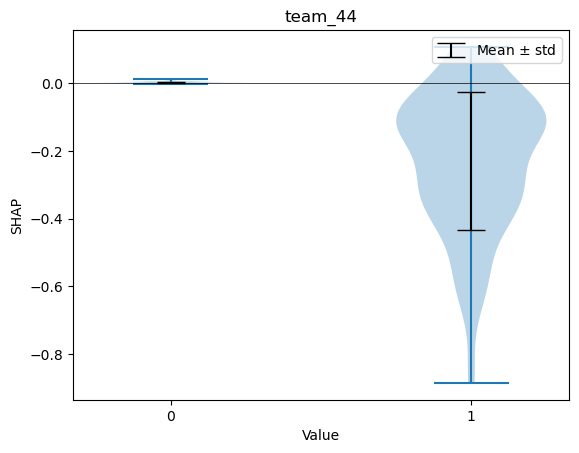

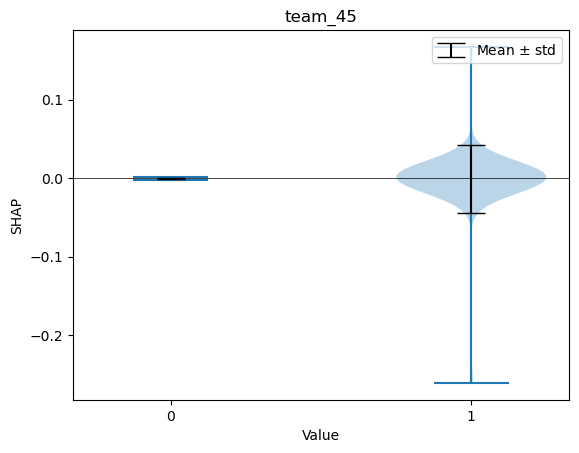

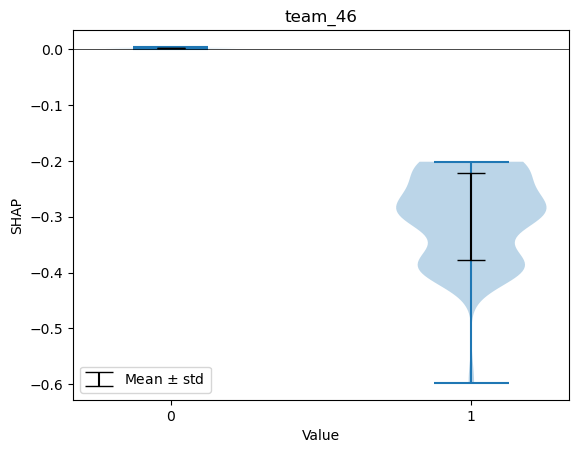

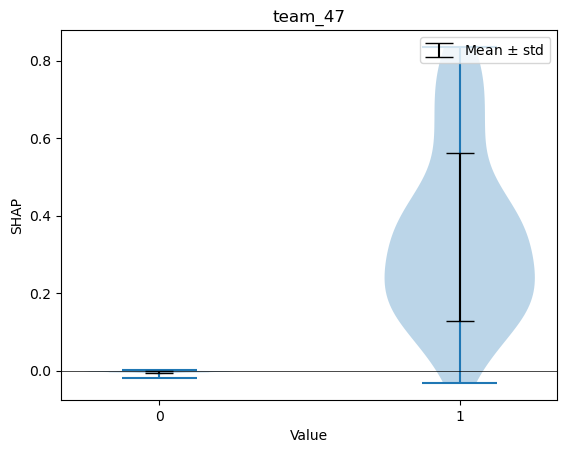

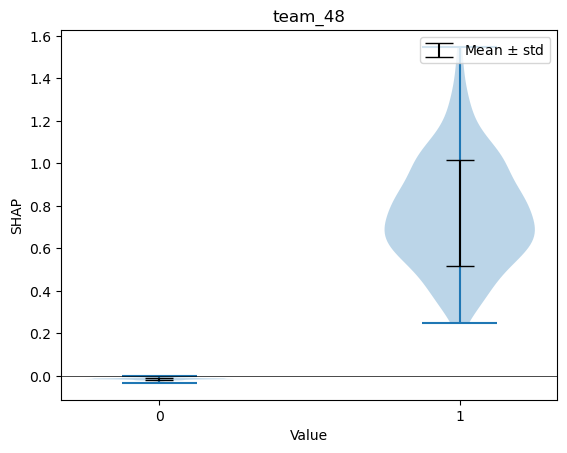

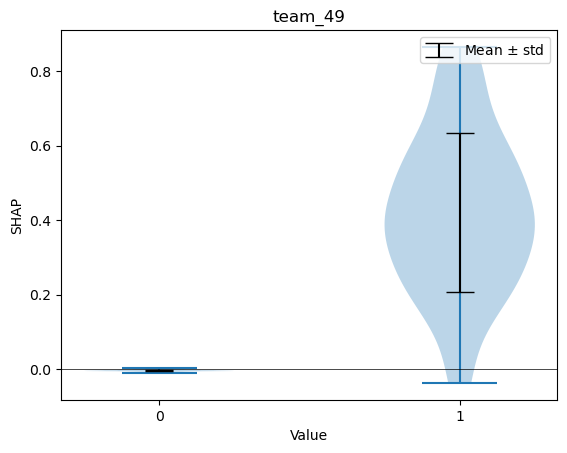

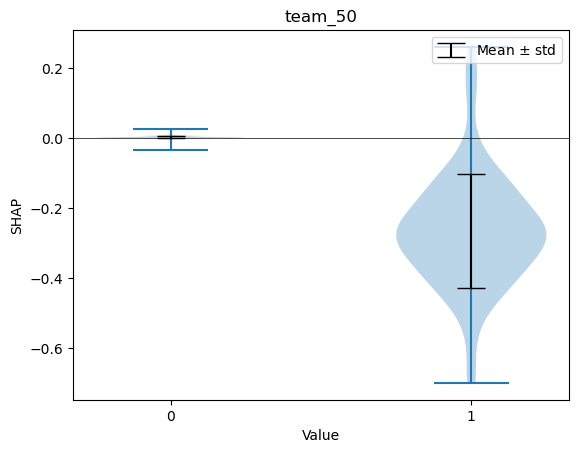

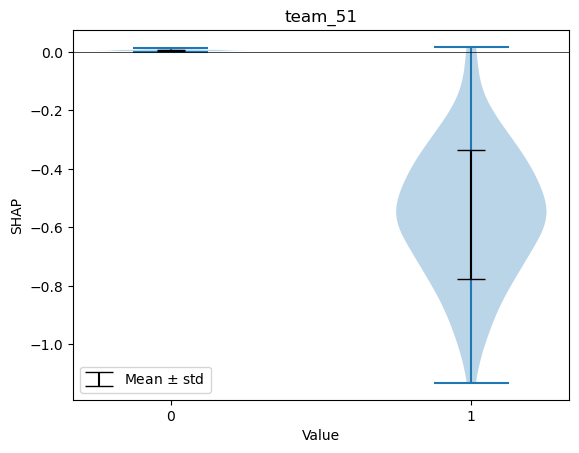

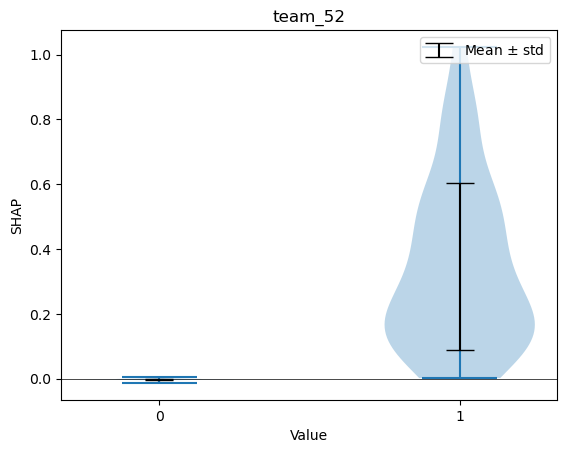

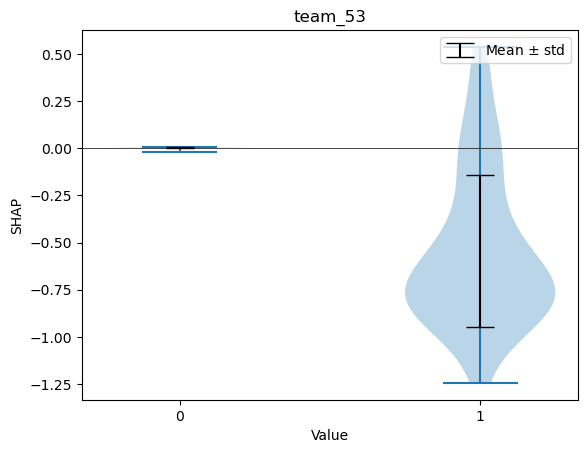

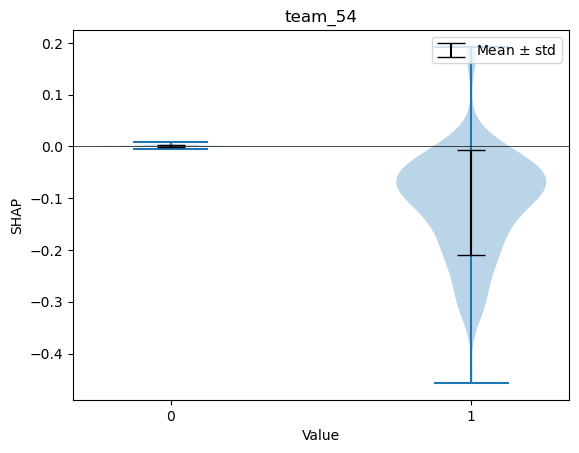

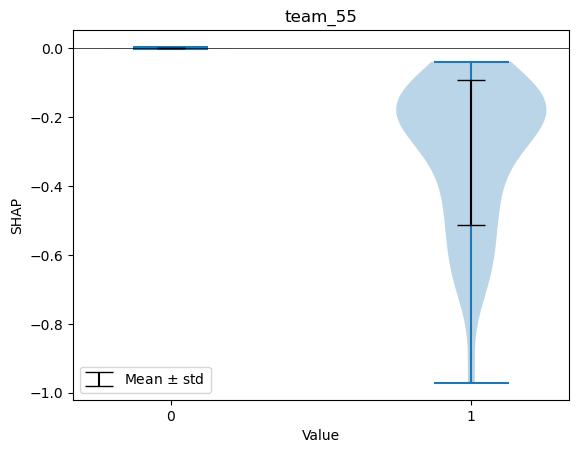

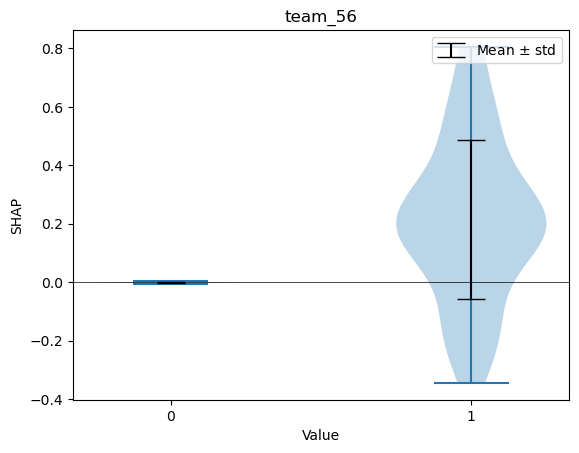

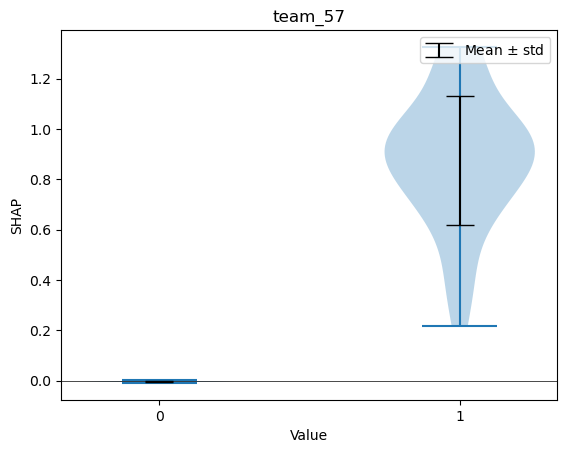

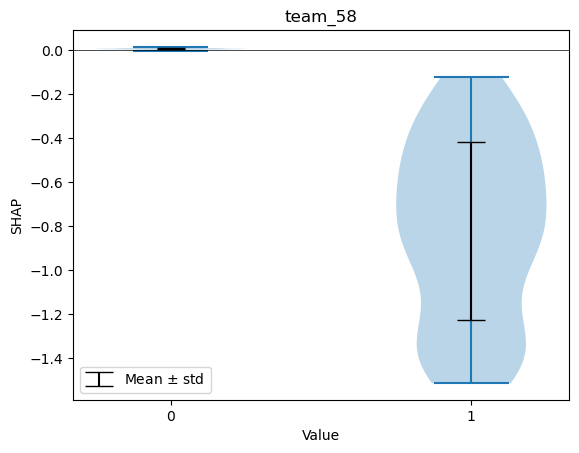

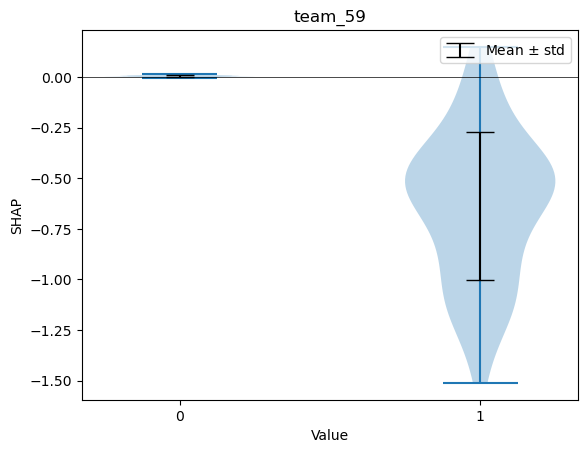

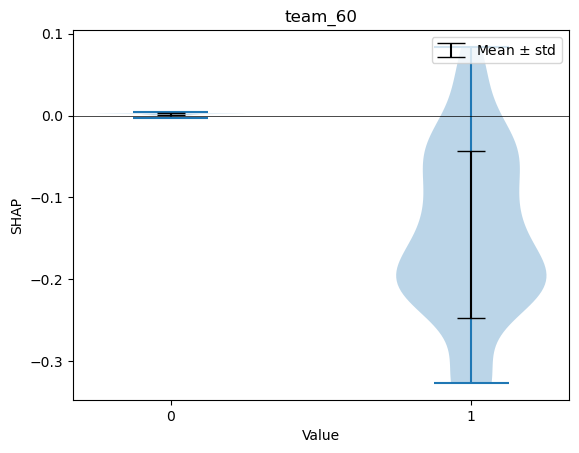

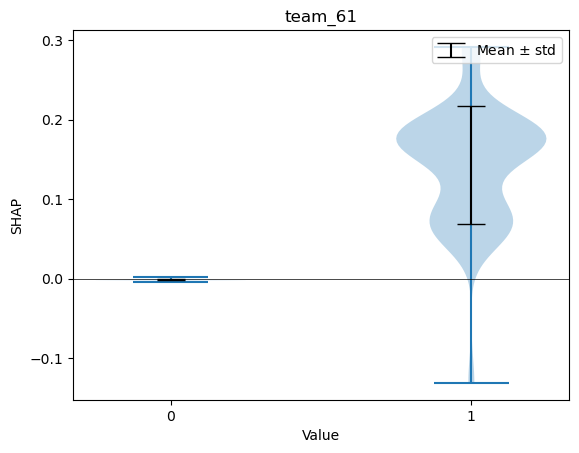

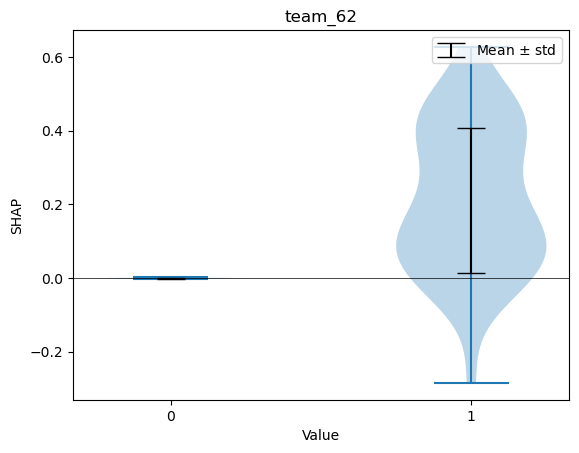

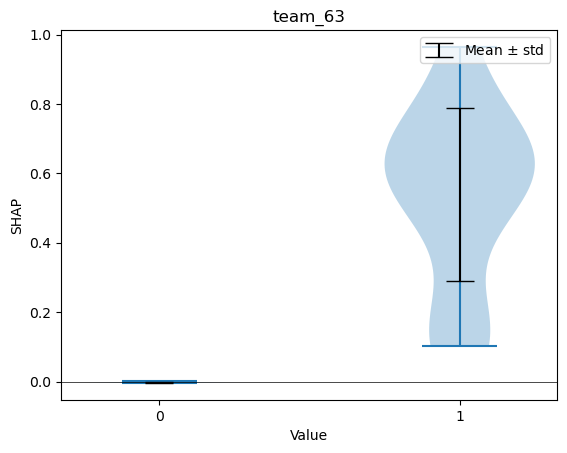

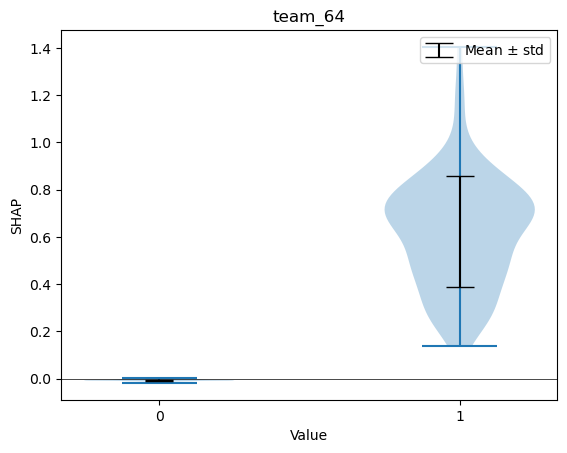

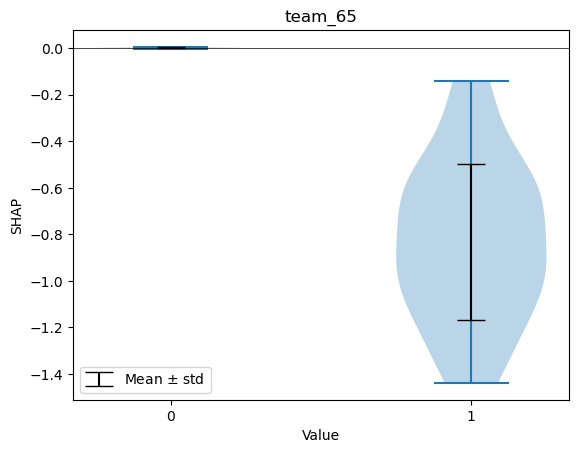

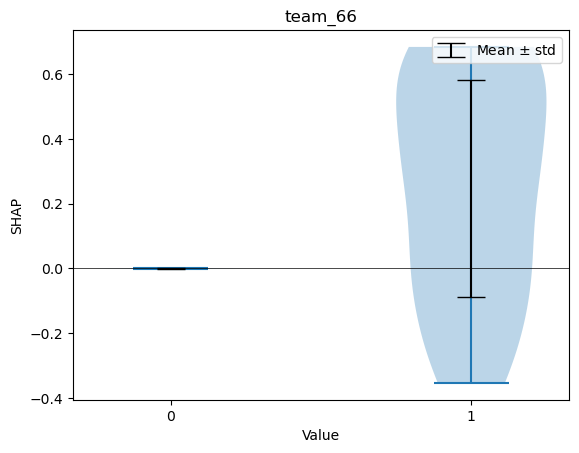

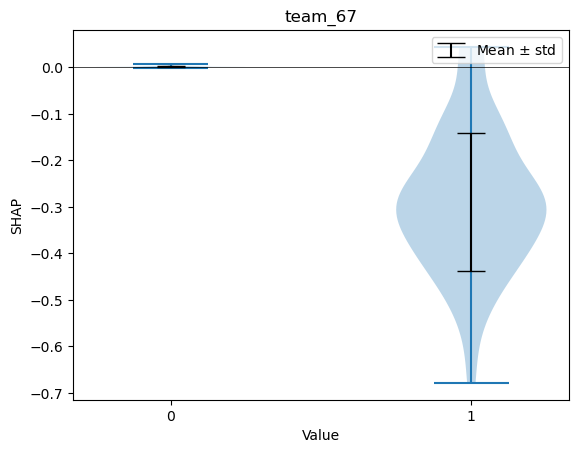

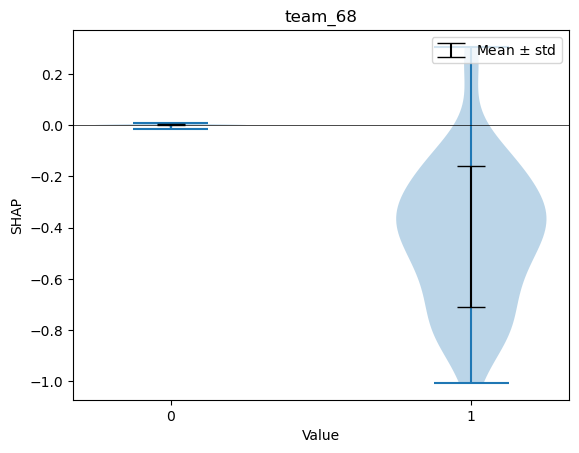

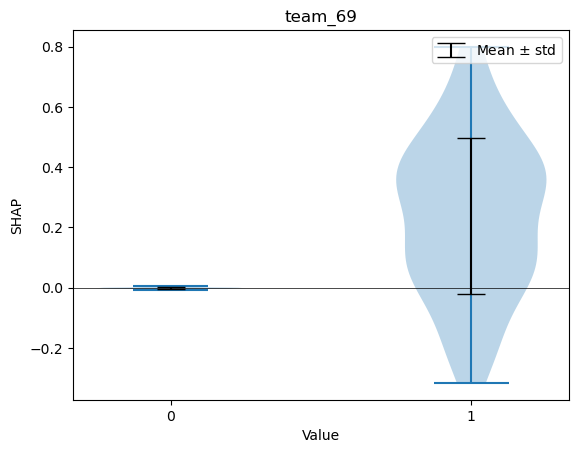

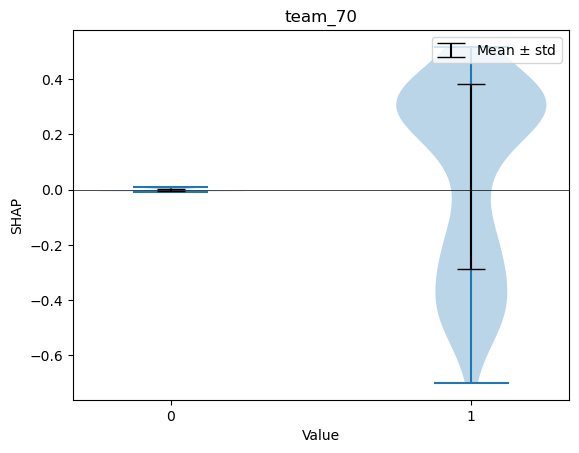

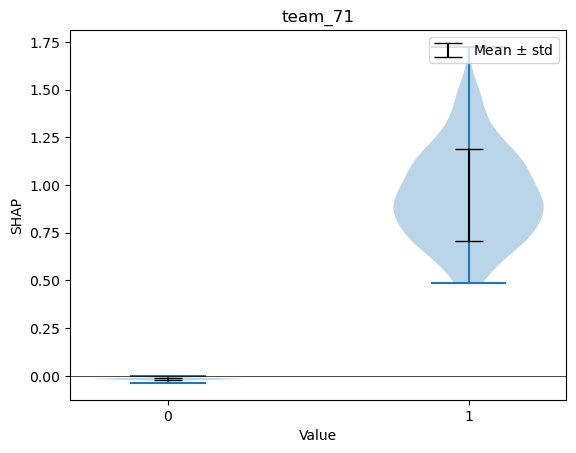

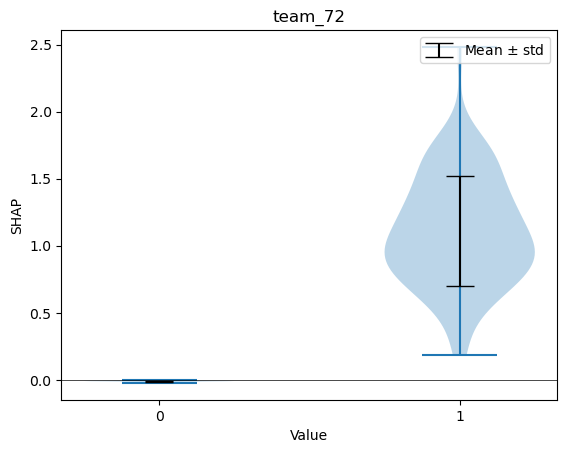

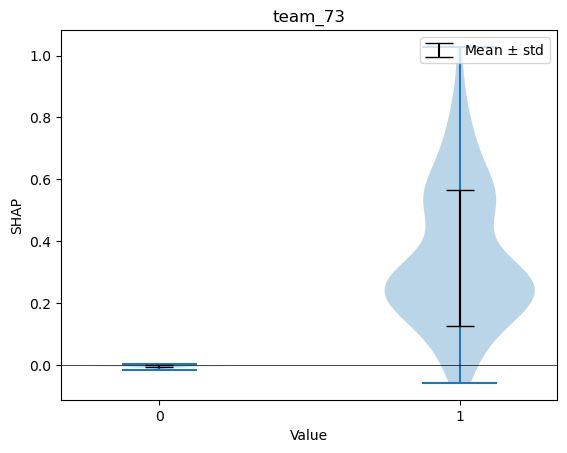

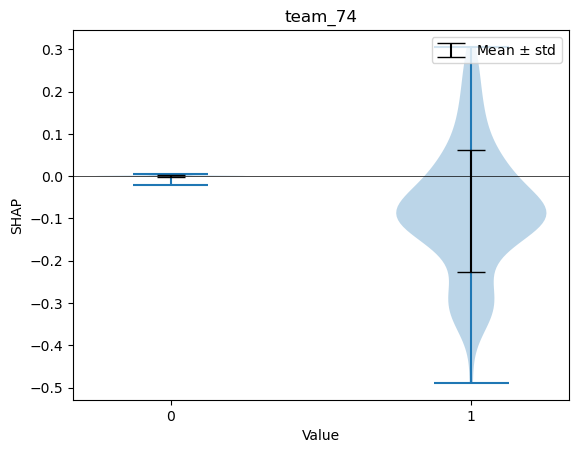

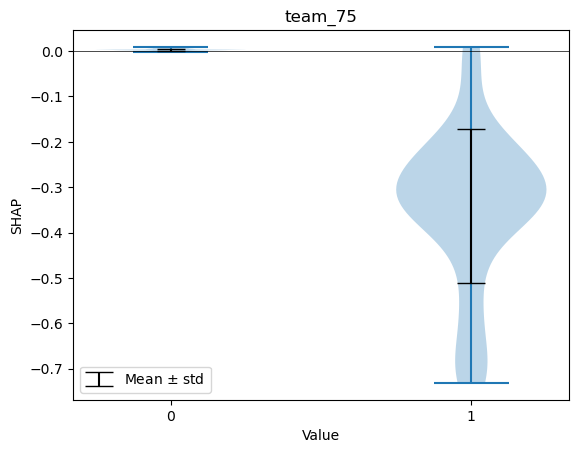

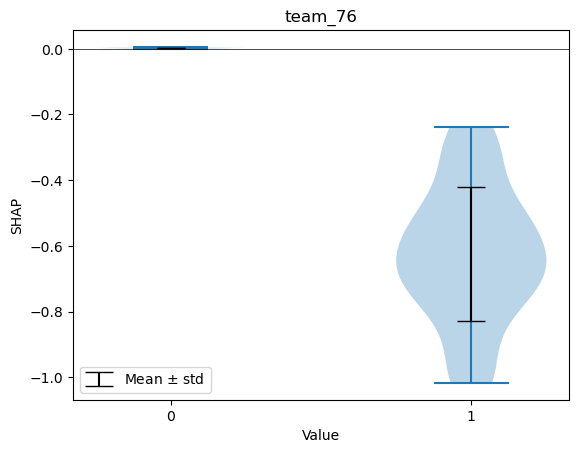

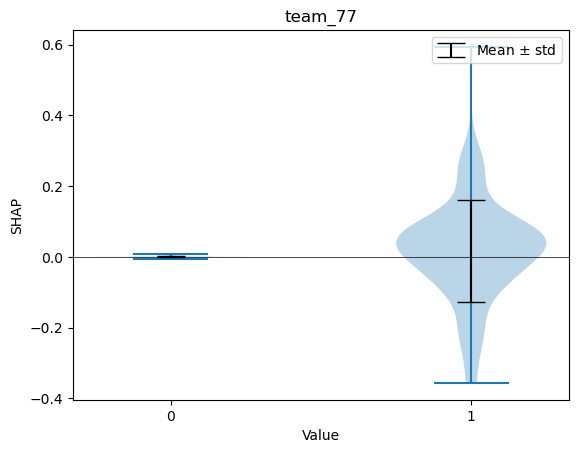

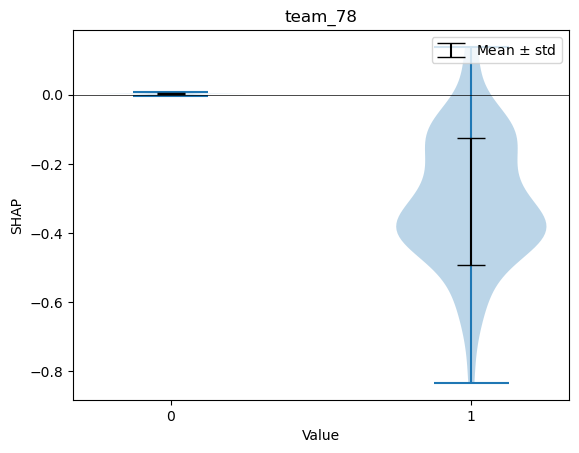

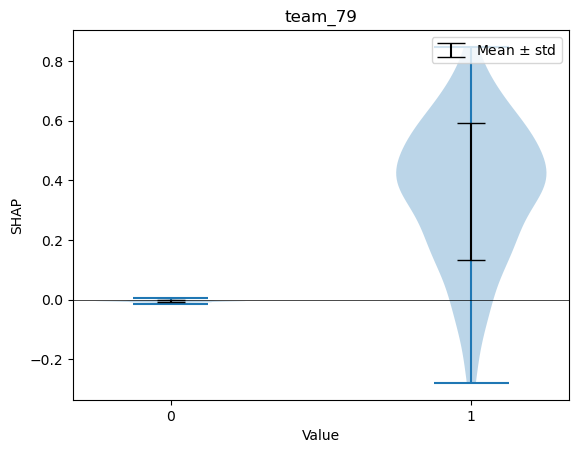

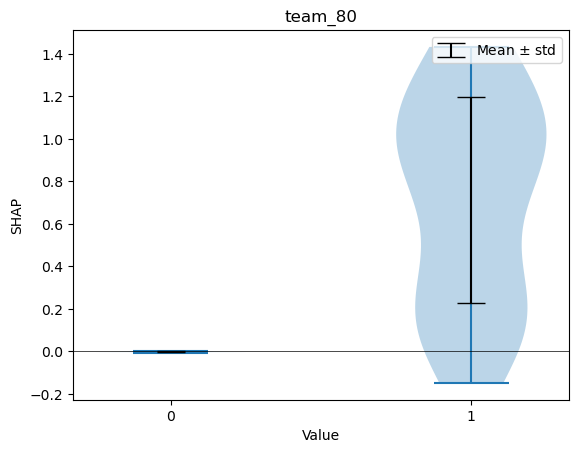

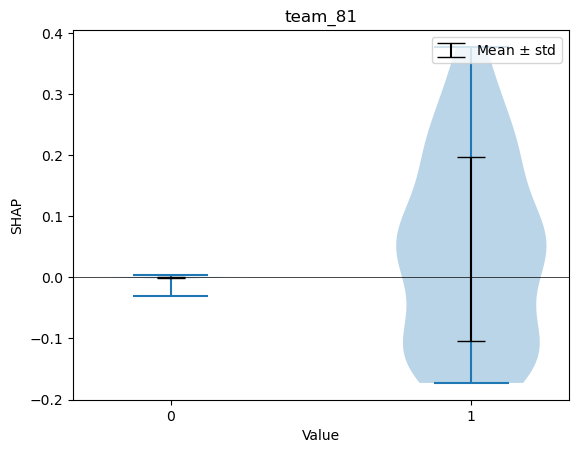

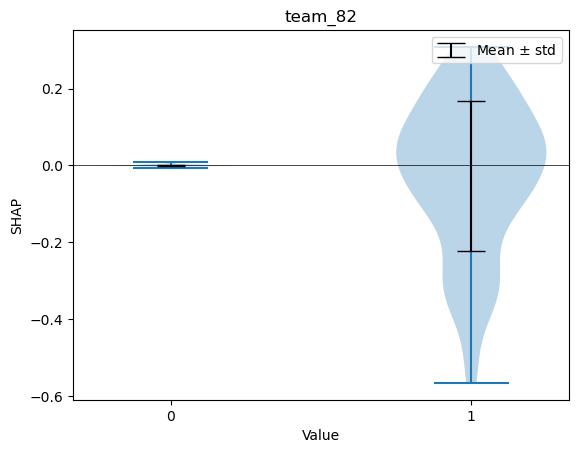

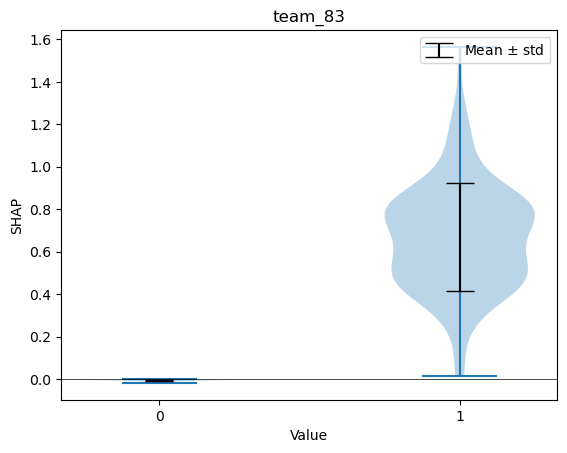

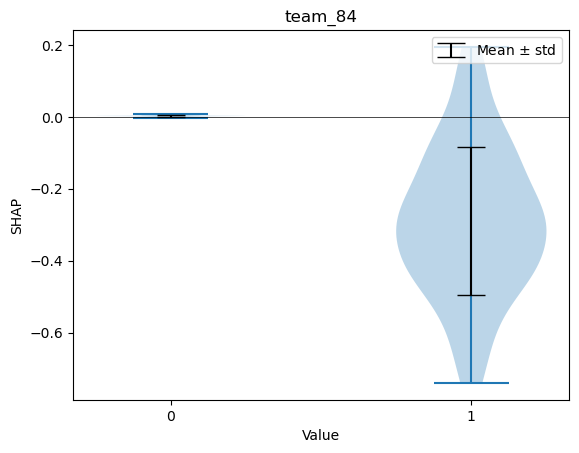

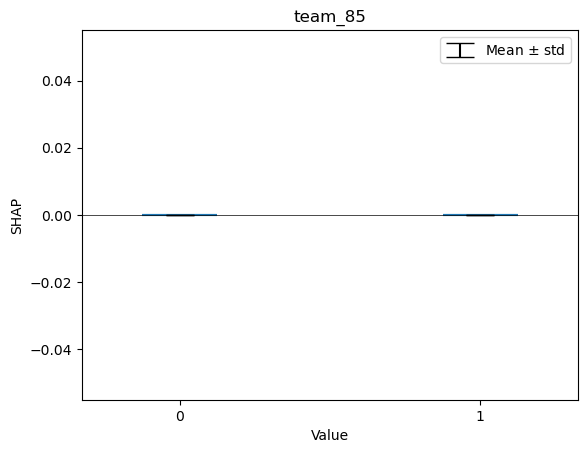

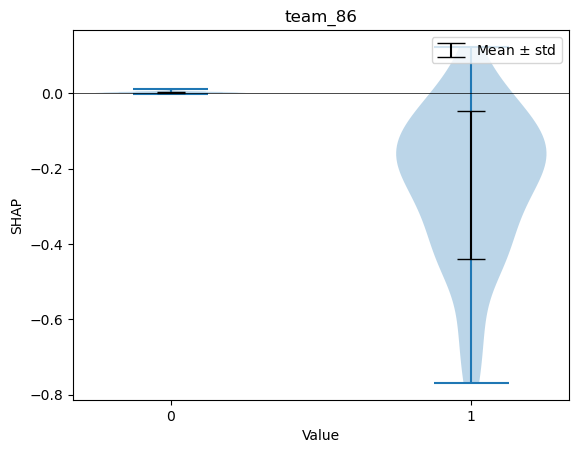

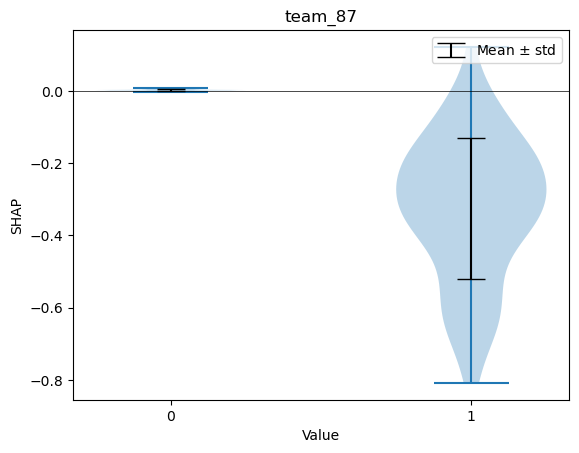

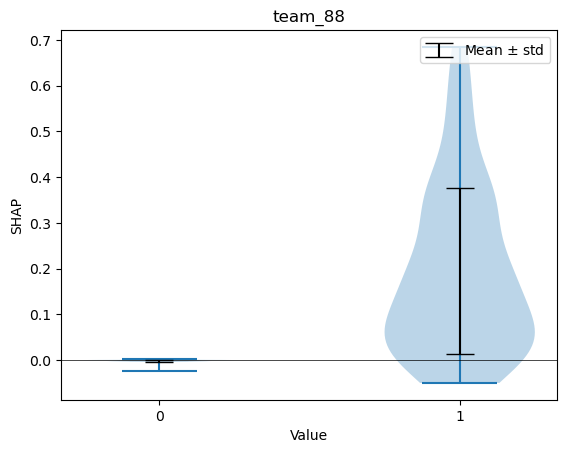

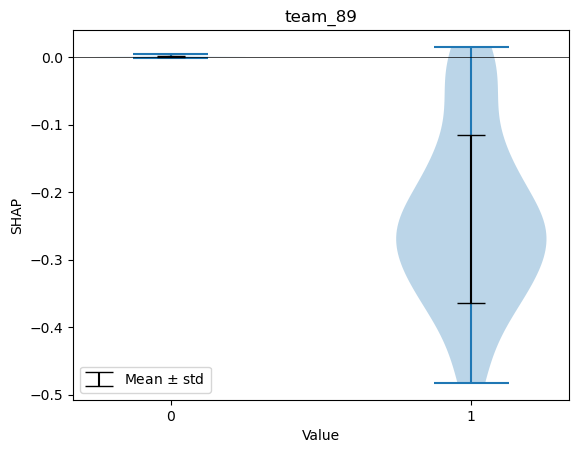

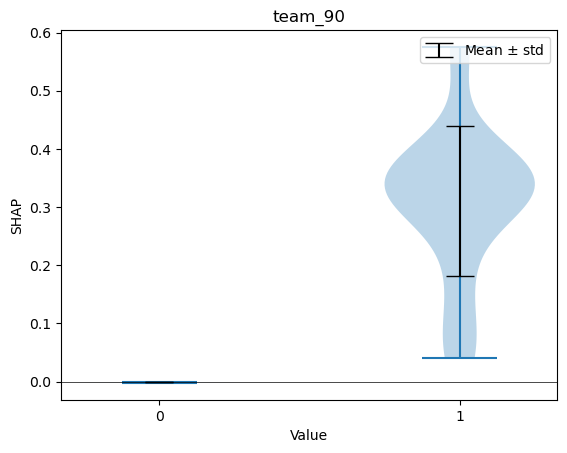

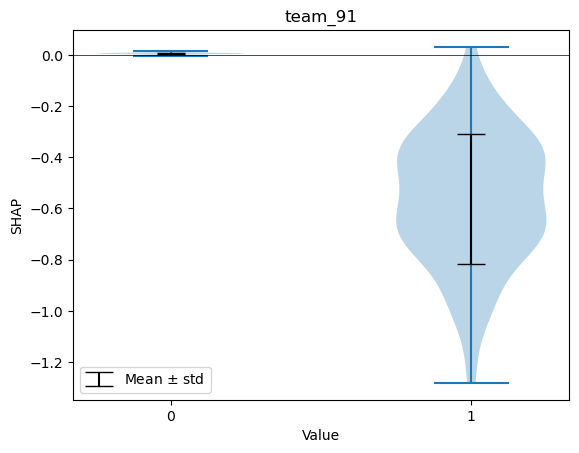

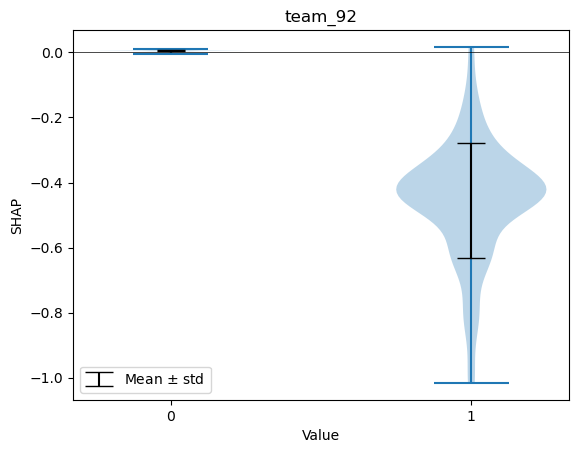

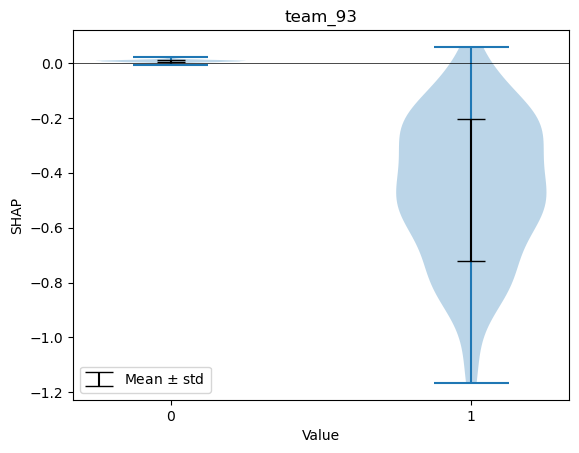

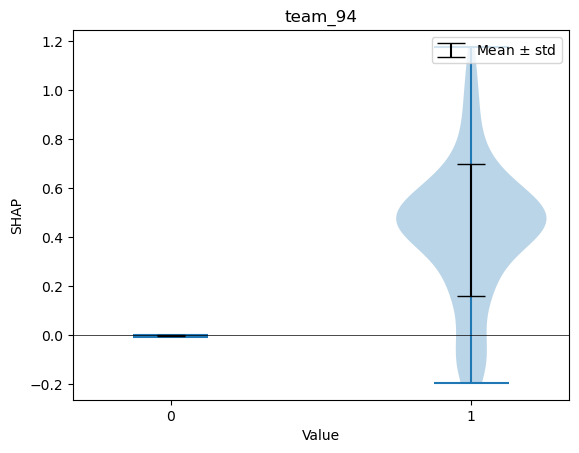

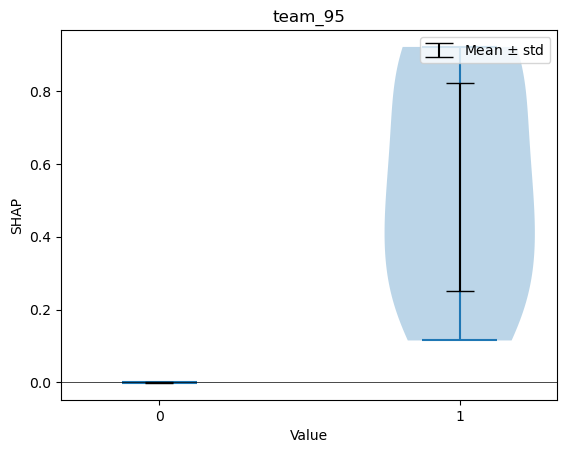

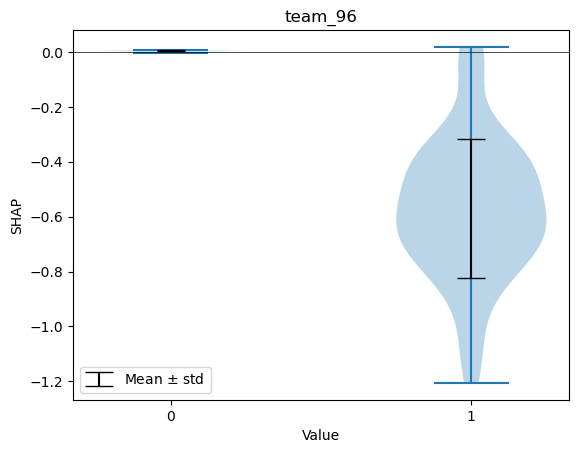

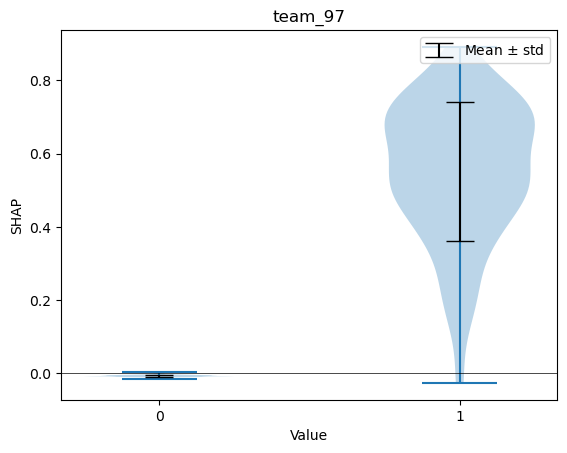

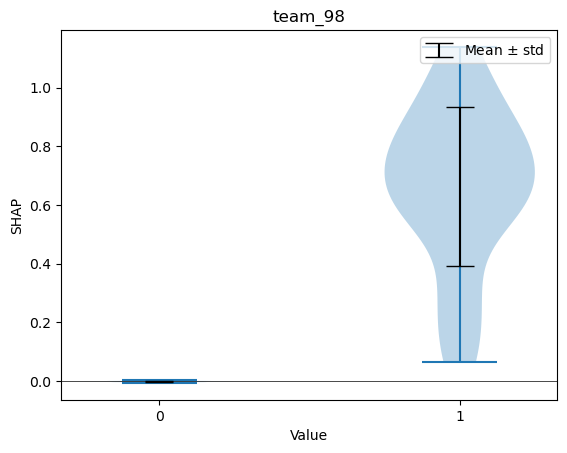

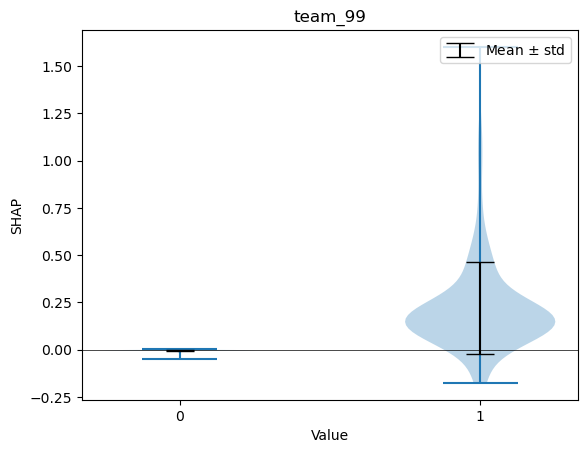

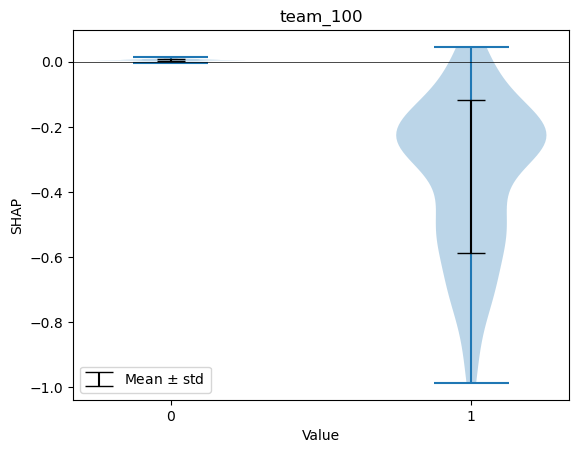

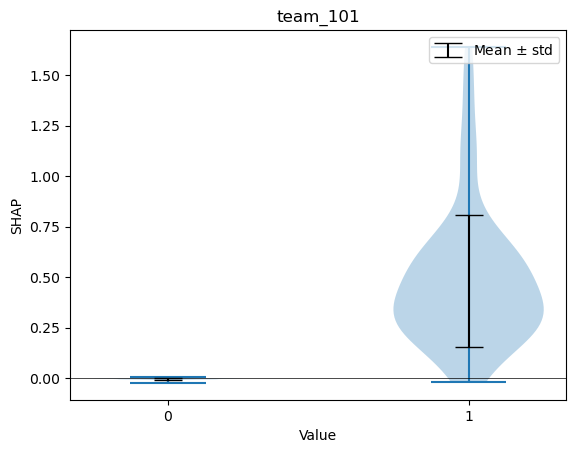

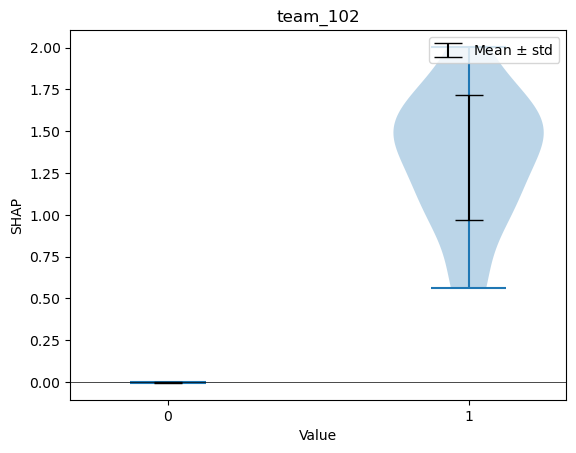

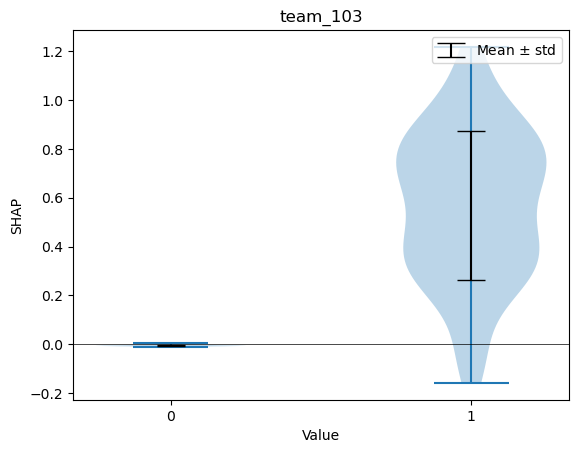

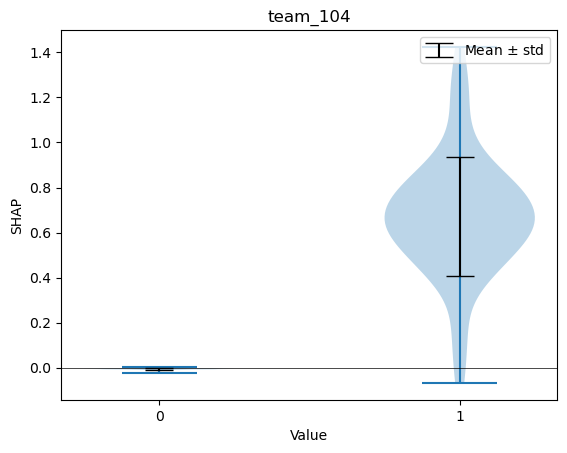

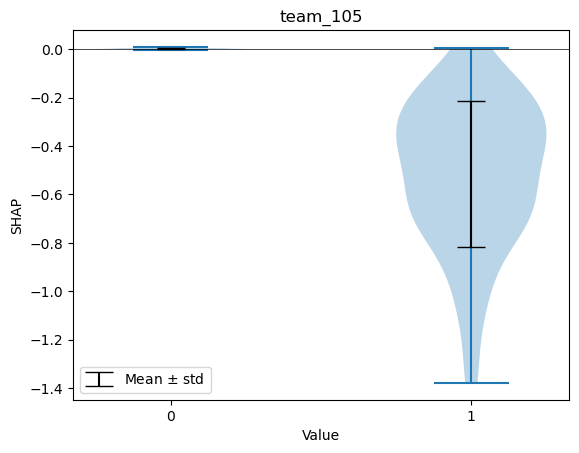

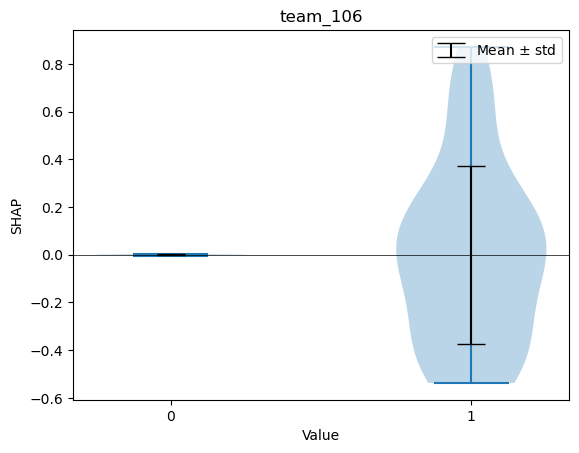

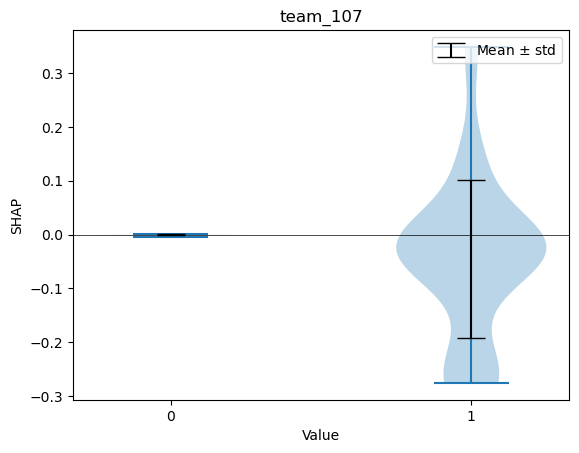

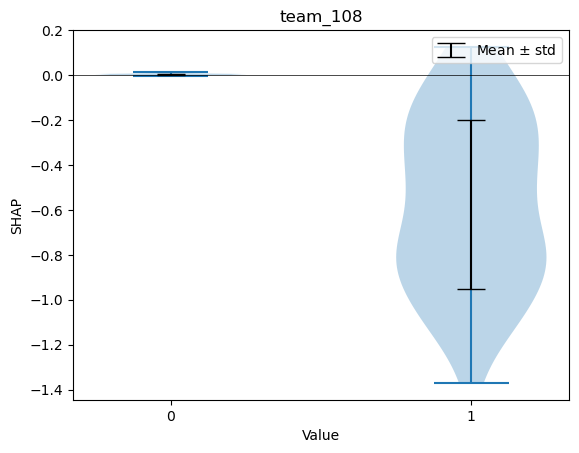

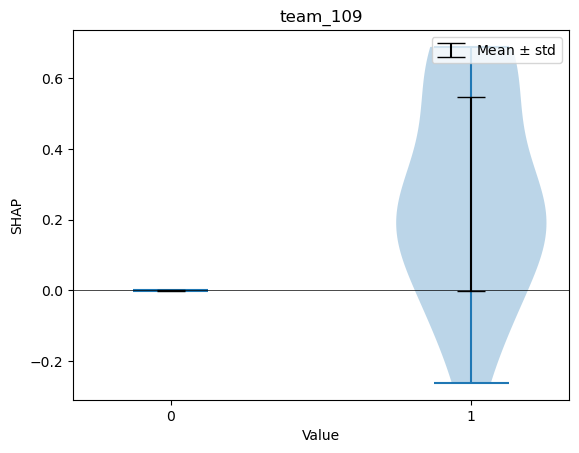

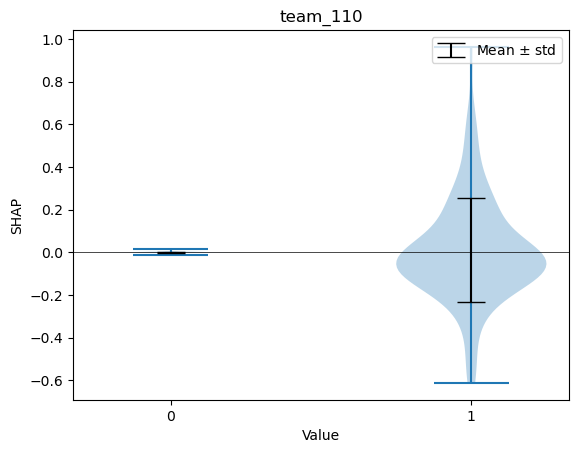

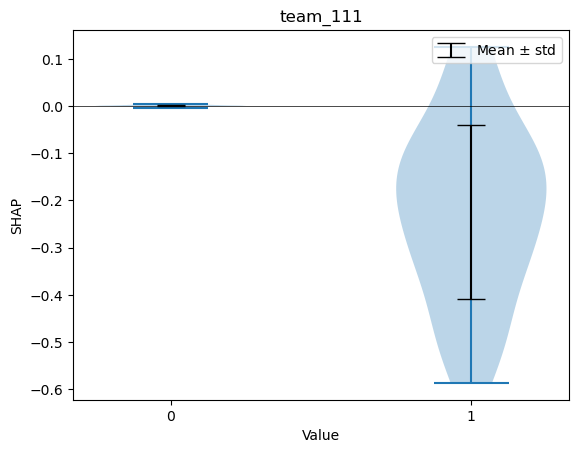

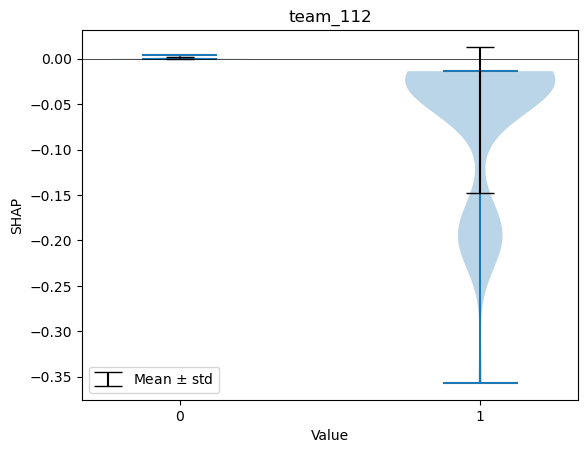

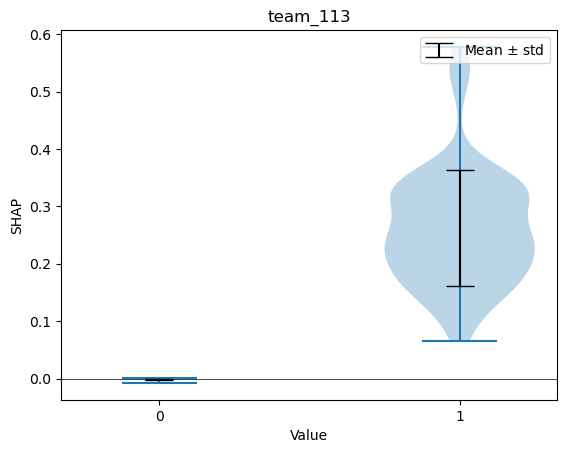

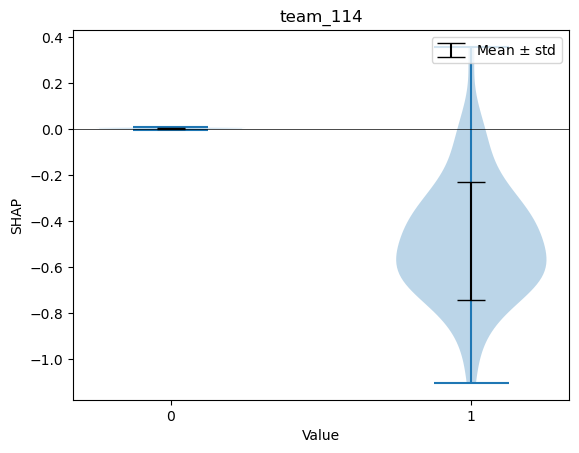

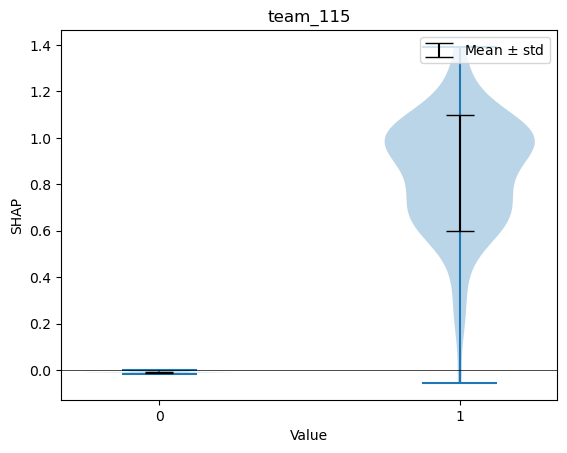

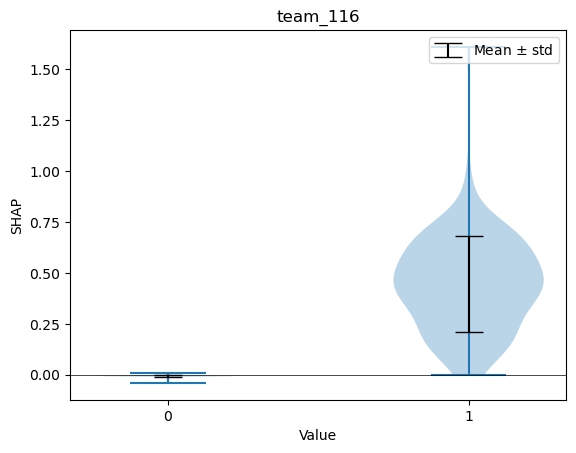

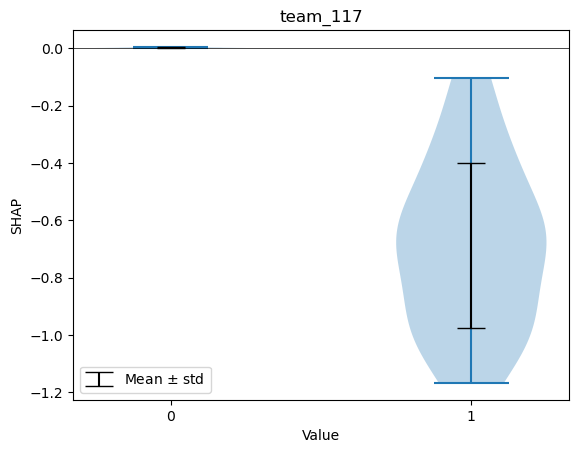

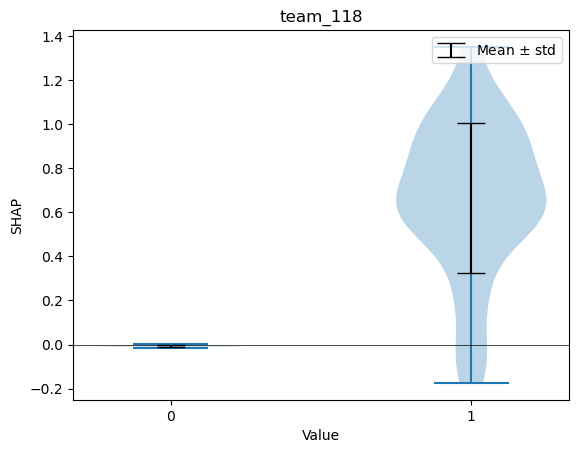

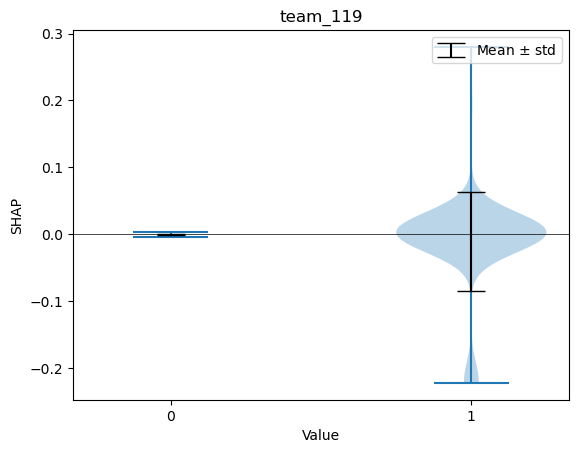

In [23]:
for f, feature in enumerate(feature_names_ohe[9:]):
    shap_dict = std_dict[feature]
    plot_violins(shap_dict, feature)